In [264]:
# Importing necessary libraries and packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import statsmodels.api as sm
import tensorflow as tf
import xgboost as xgb
import os
import warnings
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, TimeDistributed, Flatten, Dropout, RepeatVector
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss, ccf
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from math import sqrt
from sklearn.metrics import mean_squared_error
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/ap-dataset/finWeatherData.csv
/kaggle/input/ap-dataset/districts.csv
/kaggle/input/ap-dataset/AP-PowerSupplyPosition_2012-05-02_to_2023-05-14.csv
/kaggle/input/ap-dataset/APinflation.csv
/kaggle/input/ap-dataset/festivals.csv
/kaggle/input/ap-dataset/APDATA.csv


In [265]:
# Reading the demand data 
#df_weather =  pd.read_csv("/kaggle/input/weather-data/finWeatherData.csv",index_col = 0,parse_dates=True)

In [266]:
# show the first five rows of demand data
#df_weather.head()

In [267]:
# Reading the demand data 
#df_demand = pd.read_csv("/kaggle/input/power-demand-data/demand_Data.csv",parse_dates =True)

In [268]:
# show the first five rows of demand data
#df_demand.head()

In [269]:

# Convert the date column to datetime format
#df_demand['Date'] = pd.to_datetime(df_demand['Date'],errors="coerce", format="%d-%b-%y")

# Convert the date column to the desired format
#df_demand['Date'] = df_demand['Date'].dt.strftime("%Y/%m/%d")

In [270]:
#df_demand.info()

There are **null values** in demand data

In [271]:

# Convert the "Date" column in df_energy to datetime format
#df_demand['Date'] = pd.to_datetime(df_demand['Date'])

# Filter df_energy to include dates starting from 01/01/2019
#df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Convert the "Date" column in df_weather to datetime format
#df_weather['Date'] = pd.to_datetime(df_weather['Date'])

# Filter df_weather to include dates starting from 01/01/2019
#df_demand = df_demand[df_demand['Date'] >= '2019-01-01']

# Merge the two DataFrames based on the "Date" column
#merged_df = pd.merge(df_demand, df_weather, on='Date', how='inner')


In [272]:
merged_df=pd.read_csv("/kaggle/input/ap-dataset/APDATA.csv", parse_dates =True)

In [273]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1595 entries, 0 to 1594
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Date                  1595 non-null   object 
 1   Energy Required (MU)  1595 non-null   float64
 2   rain                  1595 non-null   float64
 3   temp                  1595 non-null   float64
 4   inflation             1595 non-null   float64
 5   day                   1595 non-null   object 
 6   Holiday               1595 non-null   object 
dtypes: float64(4), object(3)
memory usage: 87.4+ KB


In [274]:
merged_df["Date"] = pd.to_datetime(merged_df["Date"])

In [275]:
#creating a new feature as dayofweek
merged_df["Day"] = merged_df["Date"].dt.dayofweek

In [276]:
merged_df.drop("day",axis=1, inplace=True)

In [277]:
weather_df = pd.read_csv("/kaggle/input/ap-dataset/finWeatherData.csv",index_col=0,parse_dates =True)

In [278]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1603 entries, 0 to 1602
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    1603 non-null   object 
 1   tmax    1603 non-null   float64
 2   tmin    1603 non-null   float64
 3   rain    1603 non-null   float64
dtypes: float64(3), object(1)
memory usage: 62.6+ KB


In [279]:
weather_df =weather_df.rename(columns ={"date":"Date","tmax":"Tmax","tmin":"Tmin","rain":"Rain"})

In [280]:
weather_df["Date"]=pd.to_datetime(weather_df["Date"])

In [281]:
merged_df = pd.merge(merged_df, weather_df, on='Date', how='inner')

In [282]:
merged_df

Date  Energy Required (MU)      rain       temp  inflation Holiday  \
0    2019-01-01               152.233  0.000000  21.383461      0.020    None   
1    2019-01-02               155.343  0.000000  21.963973      0.020    None   
2    2019-01-03               157.659  0.000000  22.802453      0.020    None   
3    2019-01-04               159.317  0.000000  22.971884      0.020    None   
4    2019-01-05               159.691  0.000000  22.907513      0.020    None   
...         ...                   ...       ...        ...        ...     ...   
1590 2023-05-10               218.349  0.293171  32.032486      0.043    None   
1591 2023-05-11               219.604  0.000000  32.273232      0.043    None   
1592 2023-05-12               224.523  0.814892  32.530659      0.043    None   
1593 2023-05-13               224.030  0.000000  32.772215      0.043    None   
1594 2023-05-14               226.349  0.000000  33.595415      0.043    None   

      Day       Tmax       Tmin      Rain  
0       1  28.696802  14.070121  0.000000  
1       2  29.149151  14.778795  0.000000  
2       3  29.741541  15.863366  0.000000  
3       4  29.451434  16.492335  0.000000  
4       5  28.863384  16.951641  0.000000  
...   ...        ...        ...       ...  
1590    2  37.245505  26.819468  0.293171  
1591    3  37.272888  27.273576  0.000000  
1592    4  38.218507  26.842811  0.814892  
1593    5  38.145824  27.398606  0.000000  
1594    6  39.622750  27.568079  0.000000  

[1595 rows x 10 columns]

In [283]:
merged_df.drop(["rain","temp"],axis=1,inplace=True)

In [284]:
#Set the date column as index for better access of time series data
merged_df = merged_df.set_index("Date")

In [285]:
merged_df.isna().sum()

Energy Required (MU)    0
inflation               0
Holiday                 0
Day                     0
Tmax                    0
Tmin                    0
Rain                    0
dtype: int64

In [286]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1595 entries, 2019-01-01 to 2023-05-14
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Energy Required (MU)  1595 non-null   float64
 1   inflation             1595 non-null   float64
 2   Holiday               1595 non-null   object 
 3   Day                   1595 non-null   int64  
 4   Tmax                  1595 non-null   float64
 5   Tmin                  1595 non-null   float64
 6   Rain                  1595 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 99.7+ KB


No Null values present in the final dataframe

In [287]:
merged_df["Holiday"]=merged_df["Holiday"].apply(lambda x: 0 if x=="None" else 1)

In [288]:
merged_df[merged_df["Holiday"]==1]

Energy Required (MU)  inflation  Holiday  Day       Tmax  \
Date                                                                   
2019-01-15               148.881      0.020        1    1  29.823775   
2019-01-16               145.451      0.020        1    2  29.489232   
2019-01-26               165.945      0.020        1    5  30.220325   
2019-02-18               185.066      0.026        1    0  33.906435   
2019-03-08               195.393      0.029        1    4  34.739607   
...                          ...        ...      ...  ...        ...   
2023-04-05               227.107      0.047        1    2  35.972310   
2023-04-07               233.186      0.047        1    4  35.305988   
2023-04-14               245.632      0.047        1    4  38.982107   
2023-04-22               228.656      0.047        1    5  36.458238   
2023-05-01               176.121      0.043        1    0  30.205135   

                 Tmin       Rain  
Date                              
2019-01-15  16.884540   0.000000  
2019-01-16  17.768564   0.000000  
2019-01-26  21.298998   0.000000  
2019-02-18  22.511802   0.000000  
2019-03-08  24.490317   0.470297  
...               ...        ...  
2023-04-05  25.309858   0.392332  
2023-04-07  24.780803   1.650016  
2023-04-14  25.044151   0.003260  
2023-04-22  25.676631   1.013121  
2023-05-01  23.269369  20.552602  

[104 rows x 7 columns]

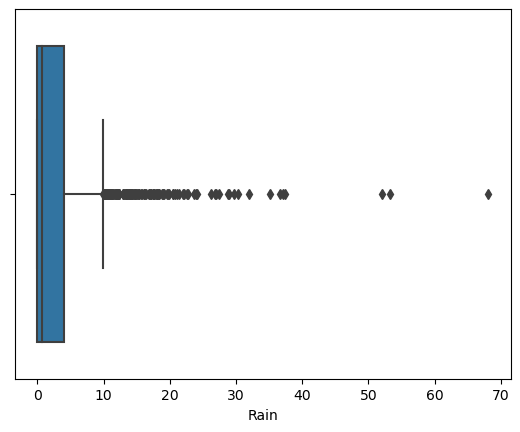

In [15]:
#plotting the boxplot for Rain column
sns.boxplot(x=merged_df['Rain'])
plt.show()

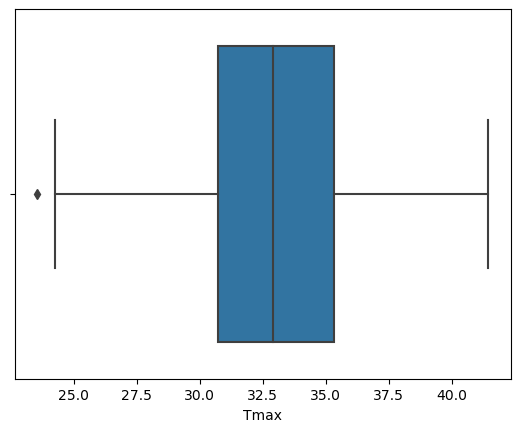

In [16]:
#plotting the boxplot for Tmax column
sns.boxplot(x=merged_df['Tmax'])
plt.show()

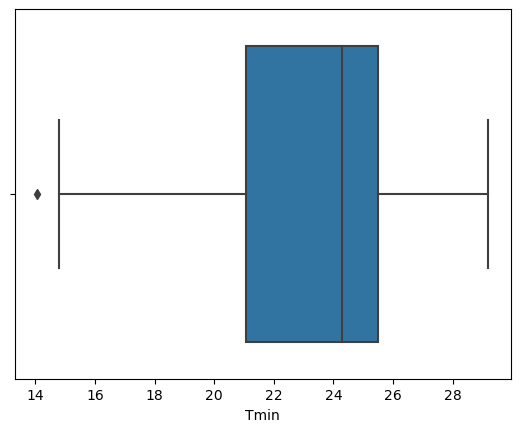

In [17]:
#plotting the boxplot for Tmin column
sns.boxplot(x=merged_df['Tmin'])
plt.show()

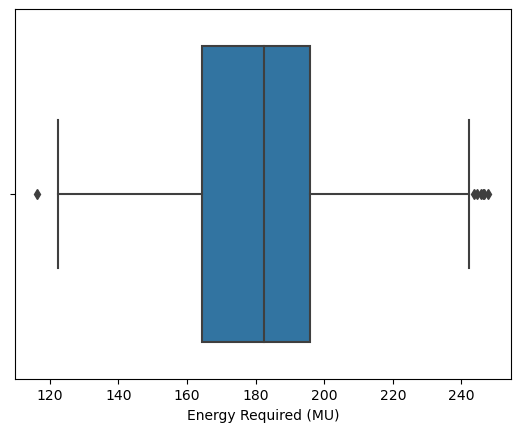

In [18]:
#plotting the boxplot for Energy demand column
sns.boxplot(x=merged_df['Energy Required (MU)'])
plt.show()

In [19]:
# Convert index to a DatetimeIndex with a frequency
merged_df.index = pd.date_range(start=merged_df.index[0], periods=len(merged_df), freq='D')

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358., 19539.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

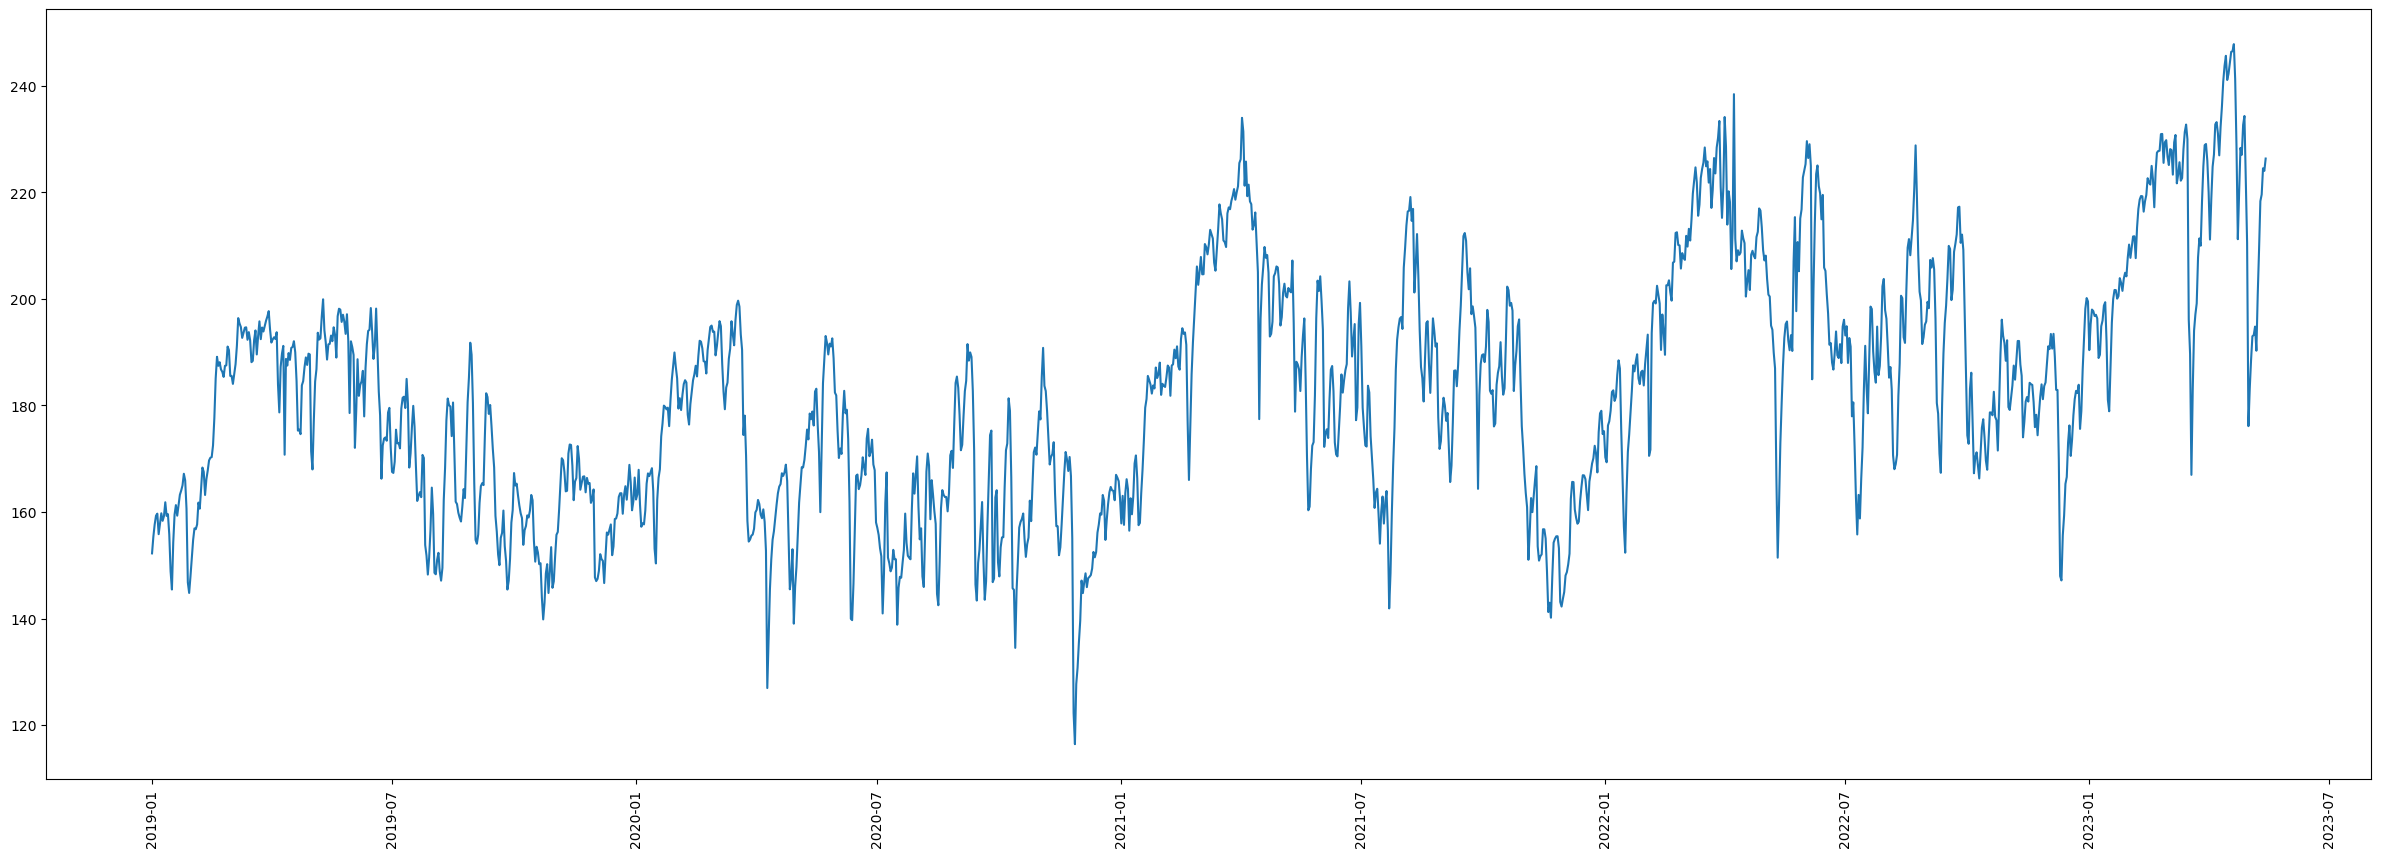

In [20]:
#plotting the Energy Required vs dates
plt.figure(figsize=(30,10))
plt.plot(merged_df["Energy Required (MU)"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358., 19539.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

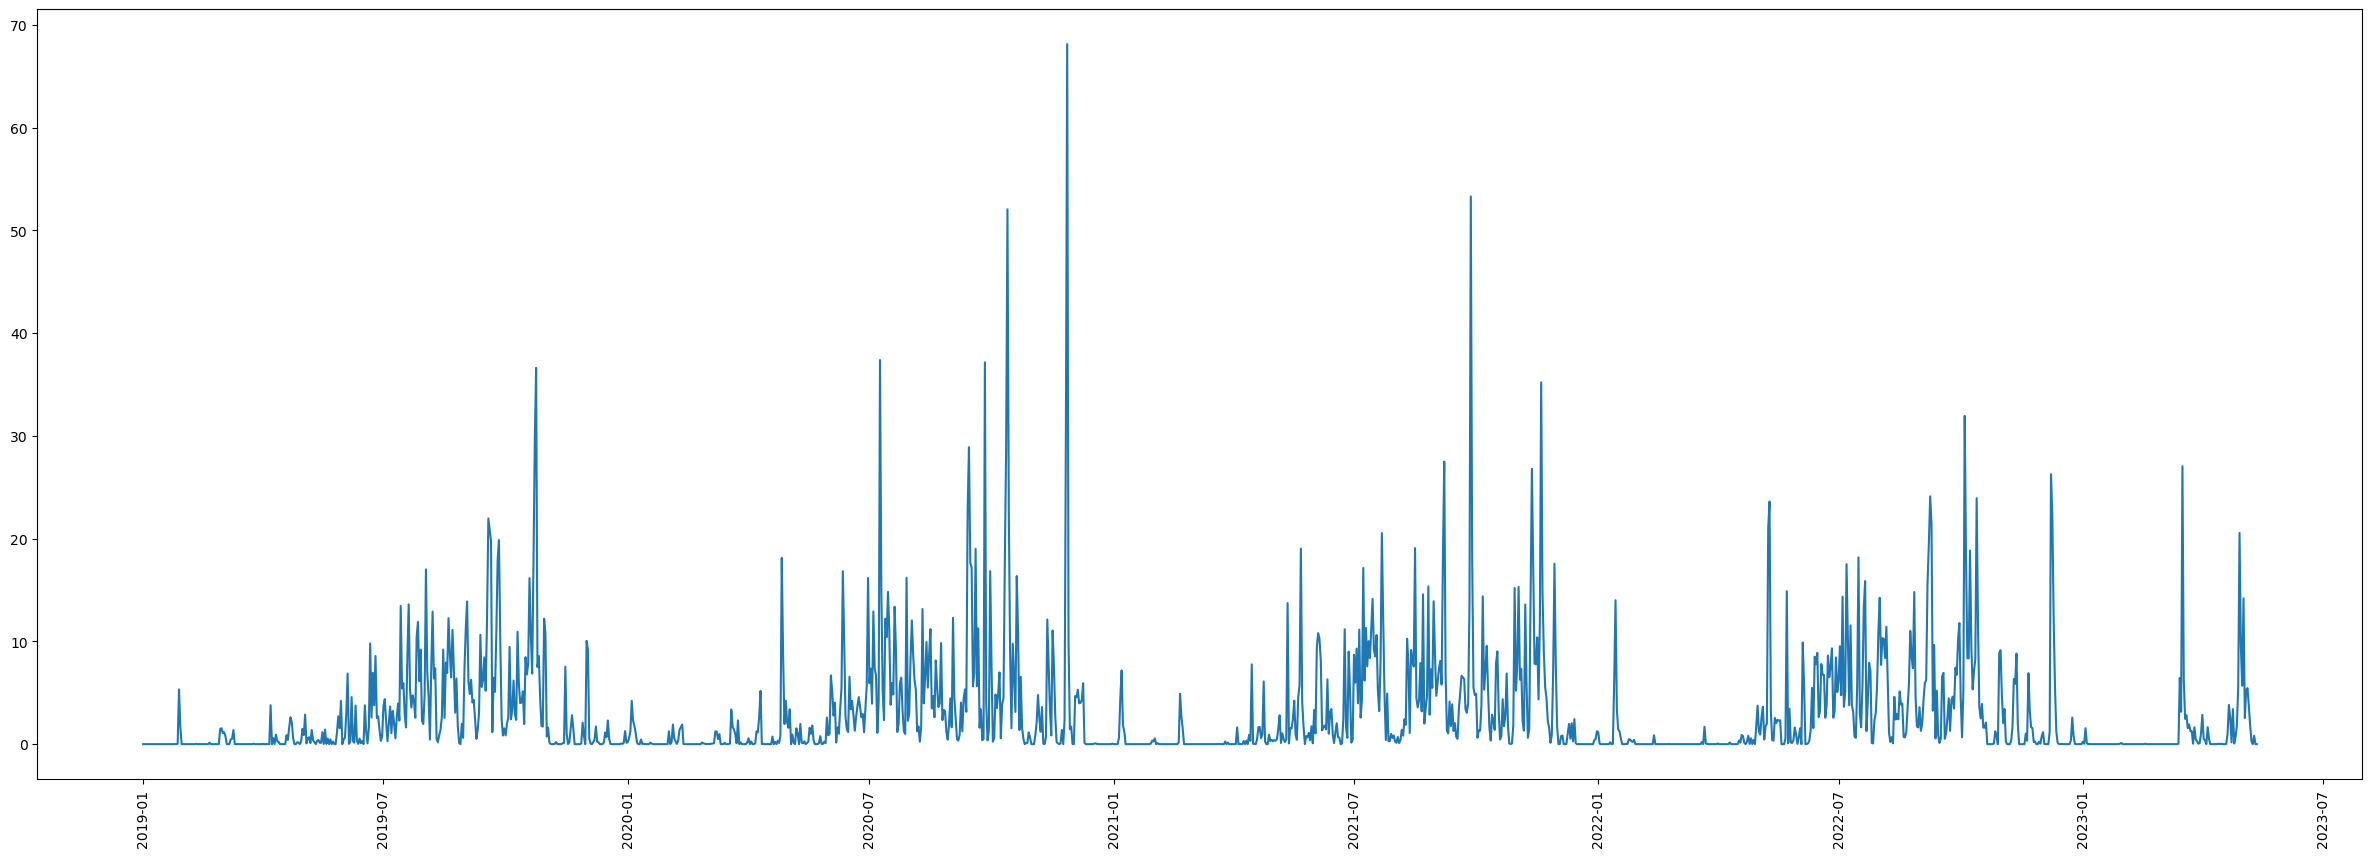

In [21]:
#Plotting rainfall vs date 
plt.figure(figsize=(30,10))
plt.plot(merged_df["Rain"])
plt.xticks(rotation=90)

(array([17897., 18078., 18262., 18444., 18628., 18809., 18993., 19174.,
        19358., 19539.]),
 [Text(17897.0, 0, '2019-01'),
  Text(18078.0, 0, '2019-07'),
  Text(18262.0, 0, '2020-01'),
  Text(18444.0, 0, '2020-07'),
  Text(18628.0, 0, '2021-01'),
  Text(18809.0, 0, '2021-07'),
  Text(18993.0, 0, '2022-01'),
  Text(19174.0, 0, '2022-07'),
  Text(19358.0, 0, '2023-01'),
  Text(19539.0, 0, '2023-07')])

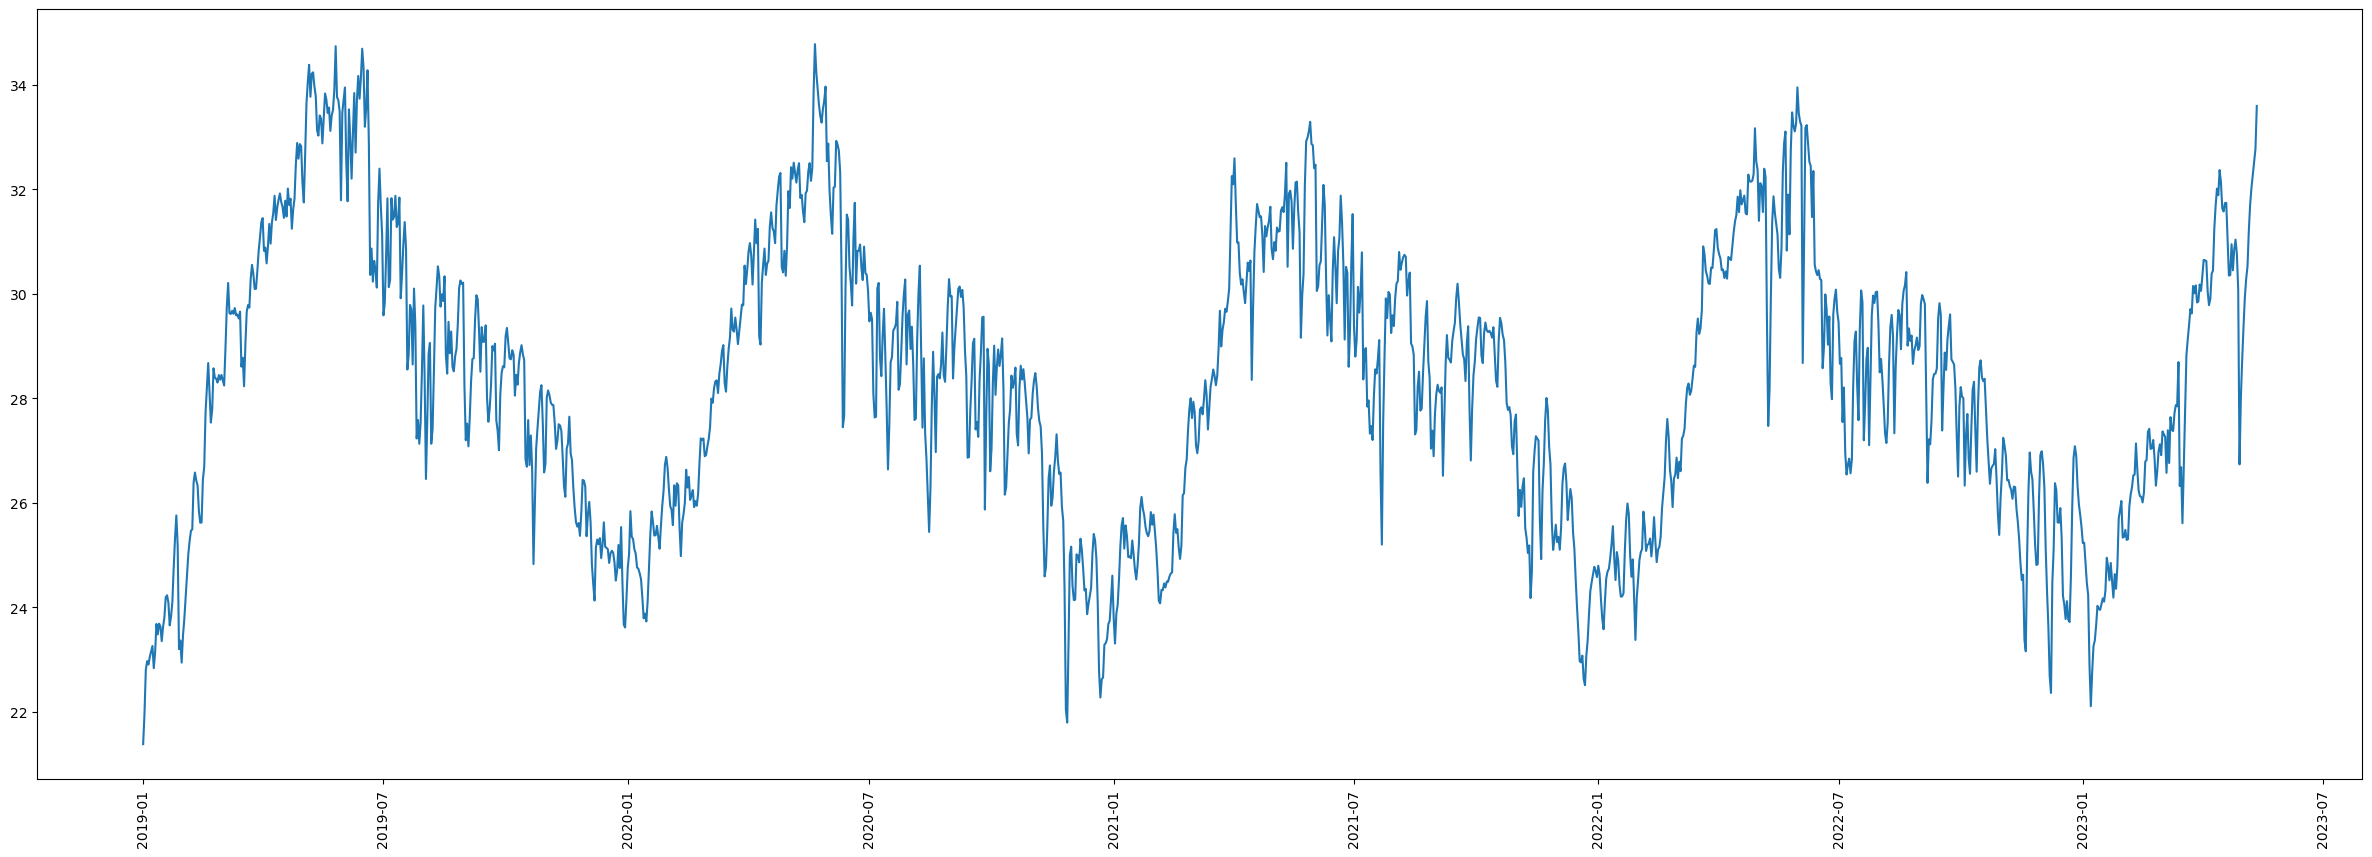

In [22]:
#plotting average temperature vs dates
plt.figure(figsize=(30,10))
plt.plot((merged_df["Tmax"]+merged_df["Tmin"])/2)
plt.xticks(rotation=90)

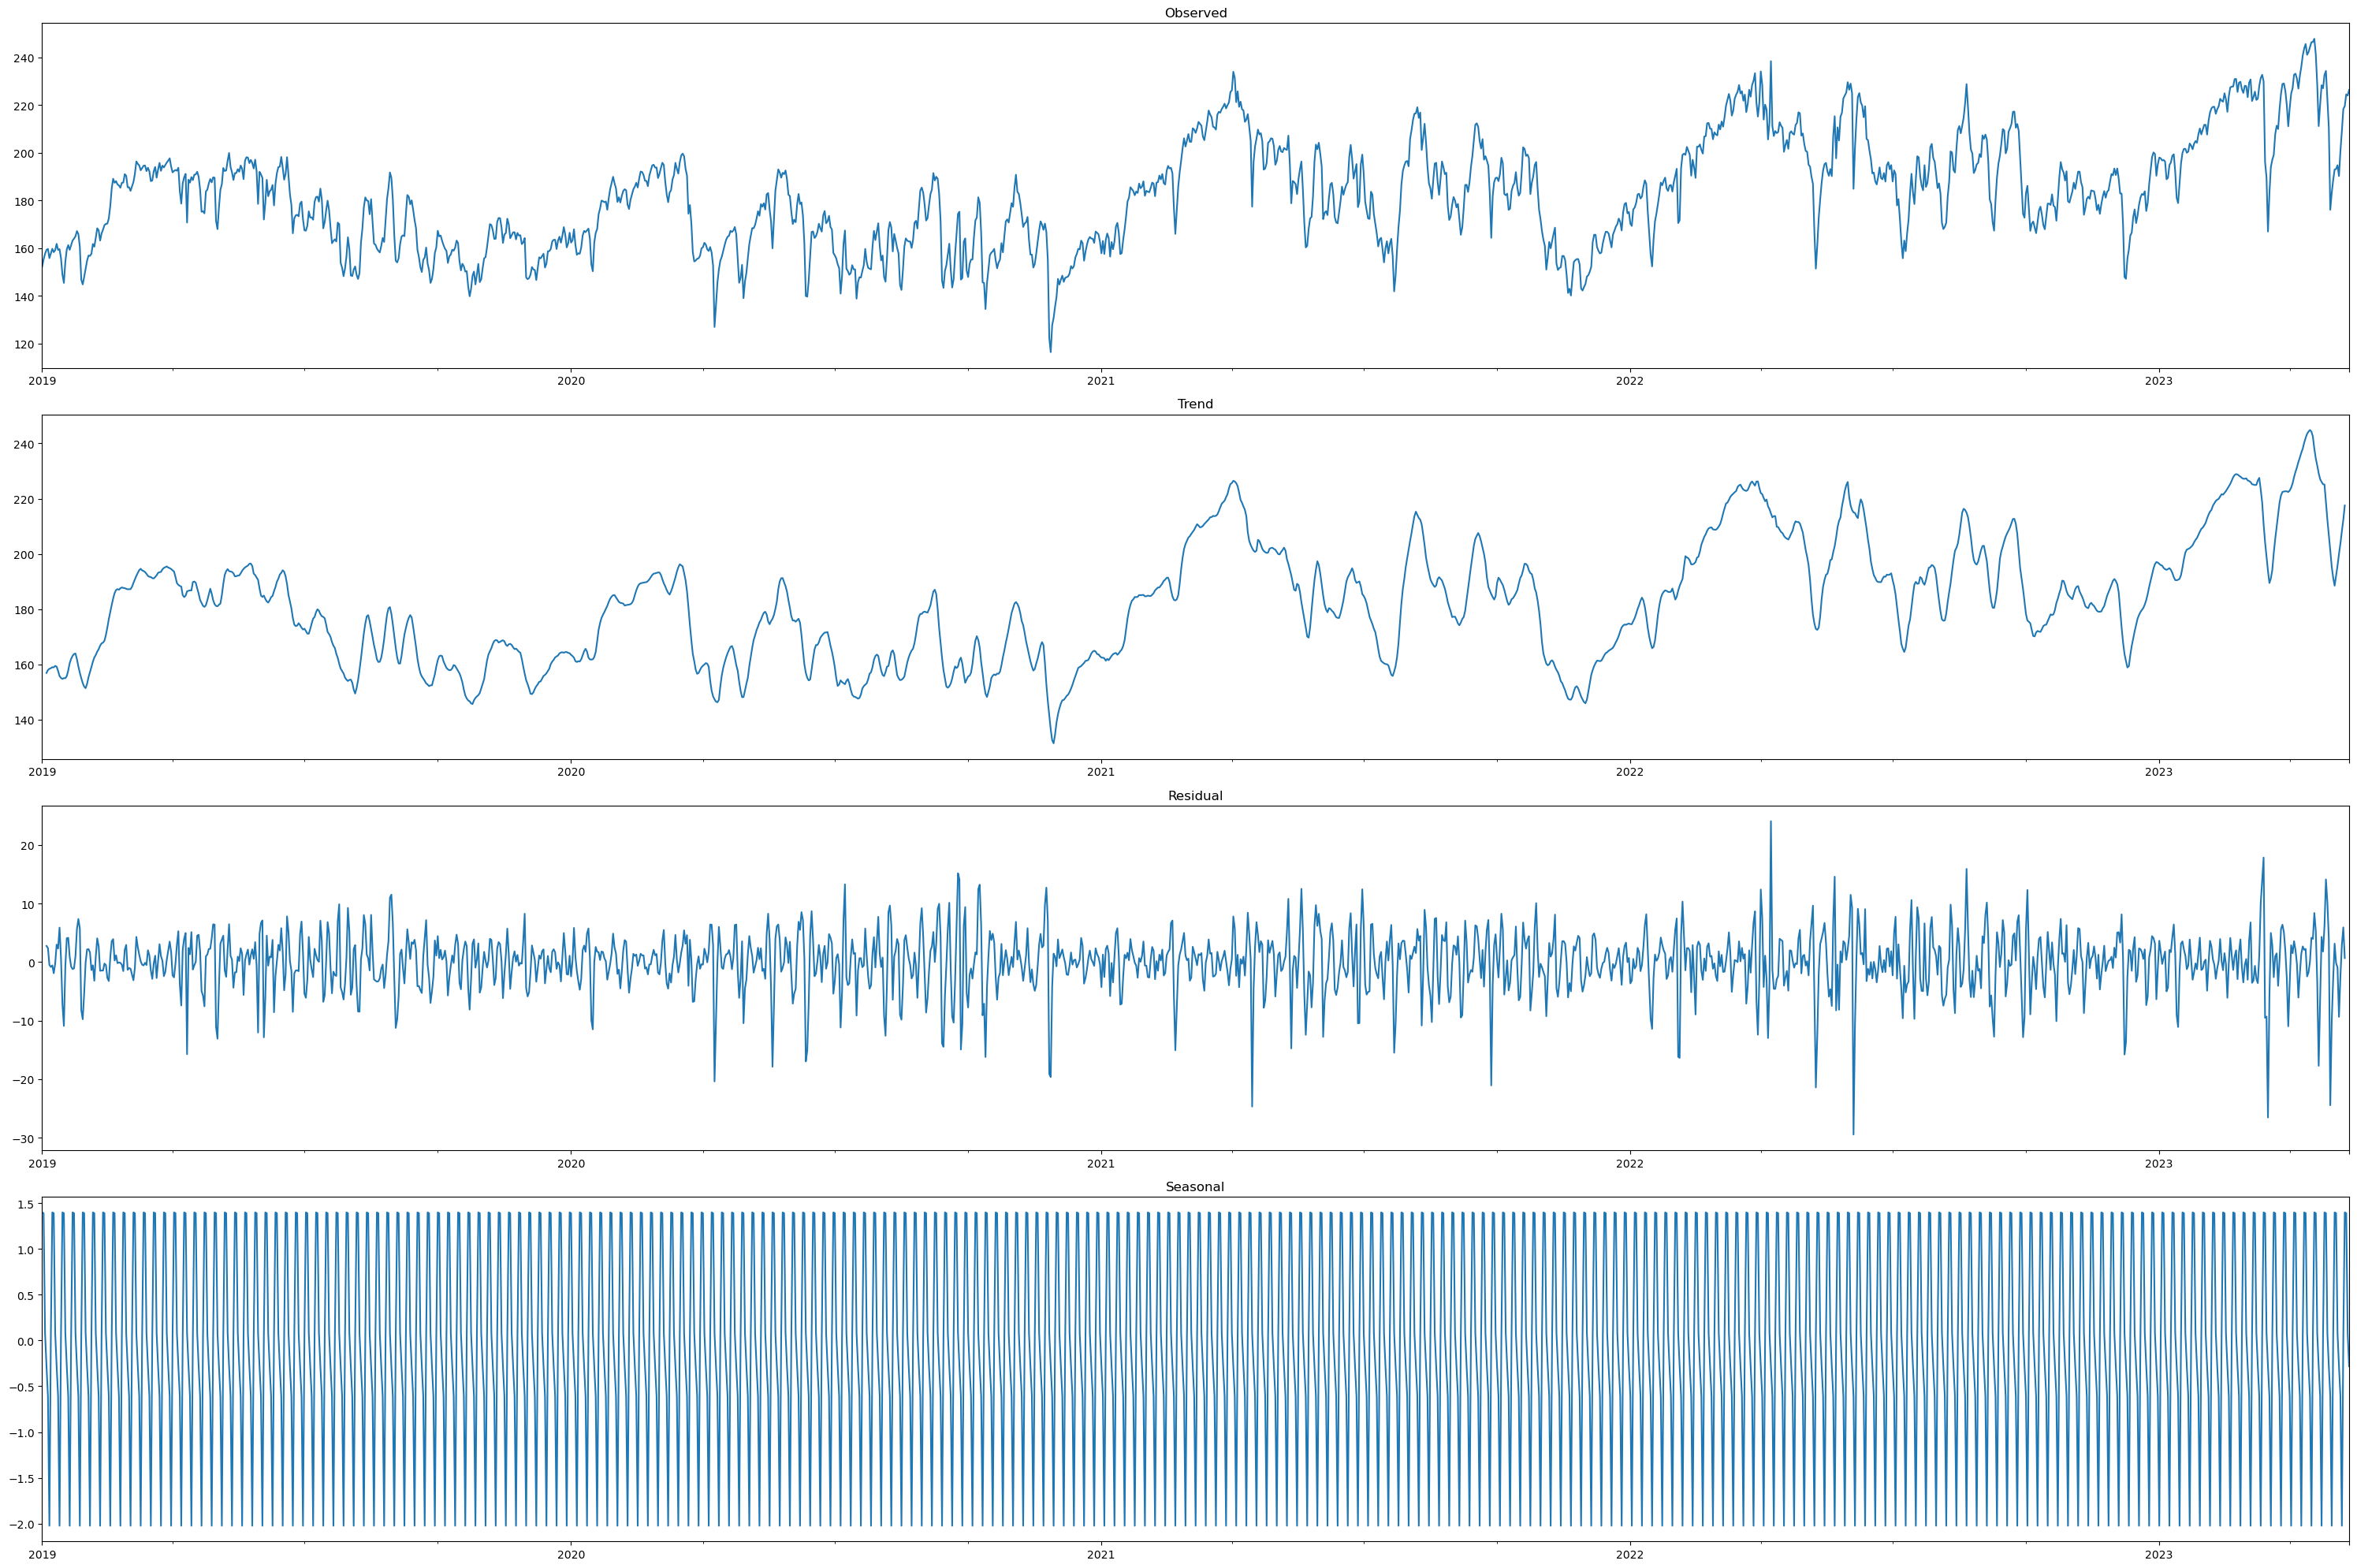

In [23]:
# Perform seasonal decomposition
res = sm.tsa.seasonal_decompose(merged_df['Energy Required (MU)'], model='additive')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 20))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

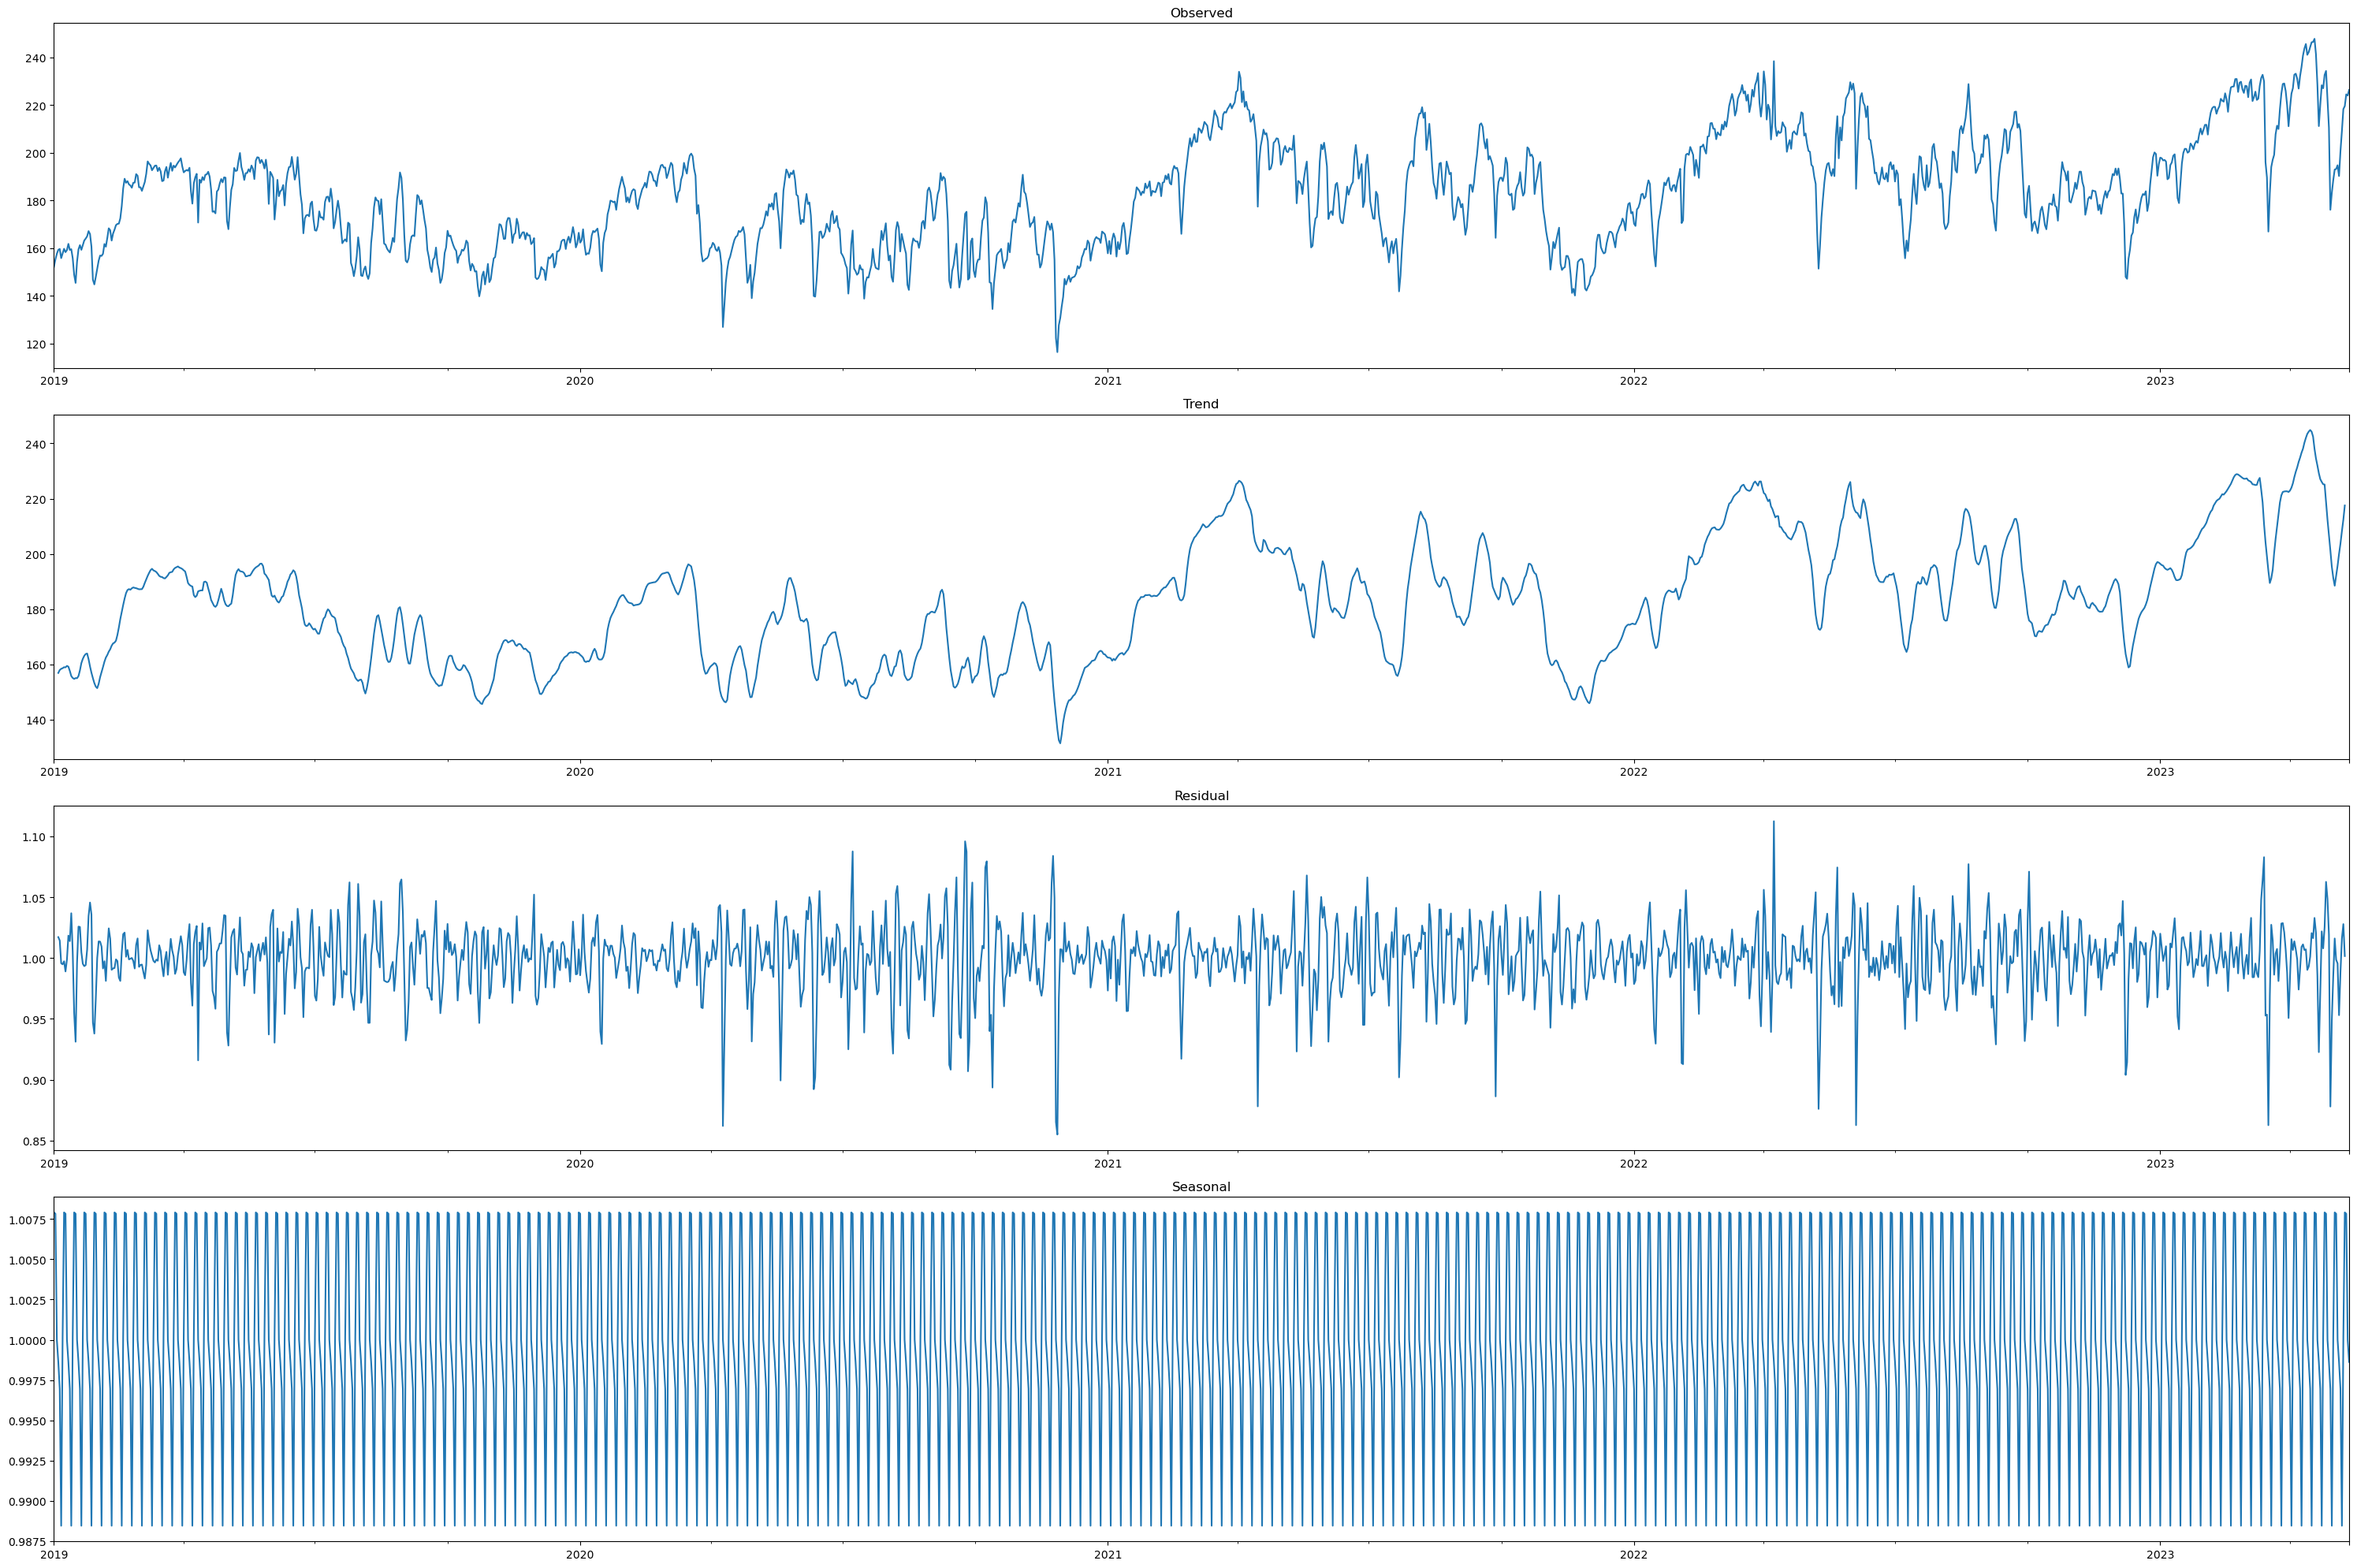

In [24]:
# Perform seasonal decomposition
res = sm.tsa.seasonal_decompose(merged_df['Energy Required (MU)'], model='multiplicative')

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 20))
res.observed.plot(ax=ax1, title='Observed')
res.trend.plot(ax=ax2, title='Trend')
res.resid.plot(ax=ax3, title='Residual')
res.seasonal.plot(ax=ax4, title='Seasonal')
plt.tight_layout()
plt.show()

In [25]:
y = merged_df['Energy Required (MU)']
adf_test = adfuller(y, regression='c')
print('ADF Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(adf_test[0], adf_test[1], adf_test[2]))
for key, value in adf_test[4].items():
    print('Critical Value ({}): {:.6f}'.format(key, value))

ADF Statistic: -3.636128
p-value: 0.005107
#Lags used: 16
Critical Value (1%): -3.434506
Critical Value (5%): -2.863376
Critical Value (10%): -2.567747


The **ADF statistic** (-3.951004) is less than the critical value at 5% (-2.863416) and thus, we can say that **we reject the null hypothesis $H_{0}$ with a significance level 1%**, meaning that there is not a root-unit in the time series and thus, that it is **either stationary or could be made stationary** with 1st order differencing (difference-stationary).

In [26]:
from statsmodels.tsa.stattools import kpss

kpss_test = kpss(y, regression='c')
print('KPSS Statistic: {:.6f}\np-value: {:.6f}\n#Lags used: {}'
      .format(kpss_test[0], kpss_test[1], kpss_test[2]))
for key, value in kpss_test[3].items():
    print(f'Critical value ({key}): {value}')


KPSS Statistic: 2.183788
p-value: 0.010000
#Lags used: 25
Critical value (10%): 0.347
Critical value (5%): 0.463
Critical value (2.5%): 0.574
Critical value (1%): 0.739


/opt/conda/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


The **KPSS statistic (1.972154)** is higher than the critical value at 5% (0.739) and thus, we can say that **we cannot reject the null hypothesis $H_{0}$ with a significance level 5%**, meaning that the **time series is stationary **or stationary around a constant.

/opt/conda/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


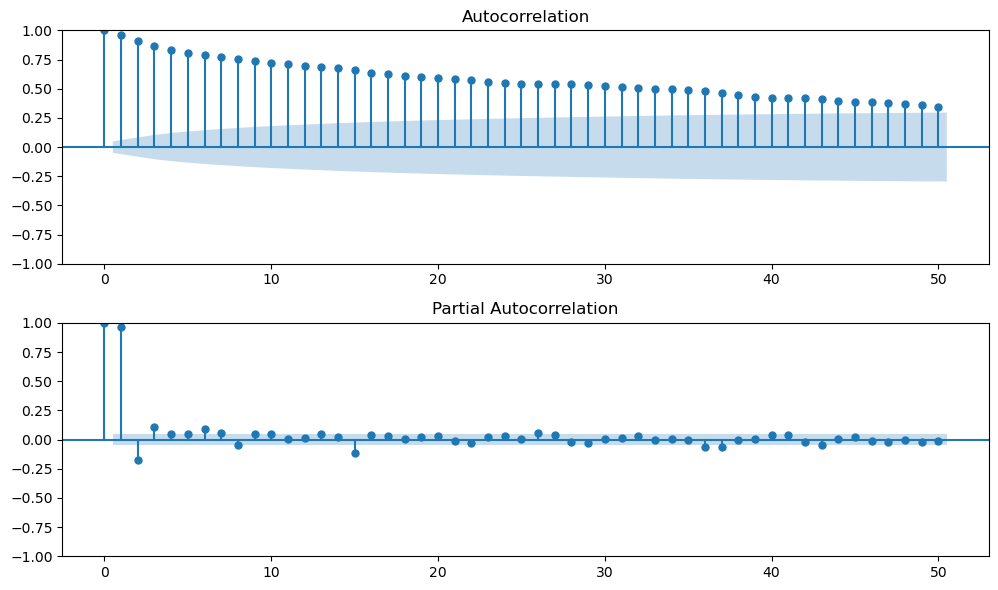

In [27]:
# Plot autocorrelation and partial autocorrelation plots

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(10, 6))
plot_acf(merged_df['Energy Required (MU)'], lags=50, ax=ax1)
plot_pacf(merged_df['Energy Required (MU)'], lags=50, ax=ax2)
plt.tight_layout()
plt.show()

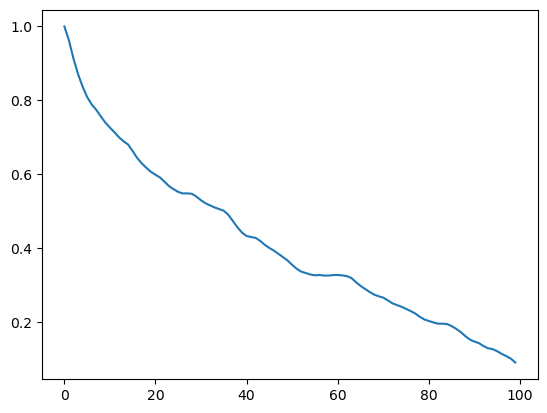

In [28]:
#plotting cross correlation plots for energy demand column
cross_corr = ccf(merged_df['Energy Required (MU)'], merged_df['Energy Required (MU)'])
plt.plot(cross_corr[0:100])
plt.show()

In [29]:
# calculating the pearson correlation coefficients
correlations = merged_df.corr(method='pearson')
print(correlations['Energy Required (MU)'].sort_values(ascending=False).to_string())

Energy Required (MU)    1.000000
Tmax                    0.523799
Tmin                    0.151125
Day                    -0.029001
Rain                   -0.378329


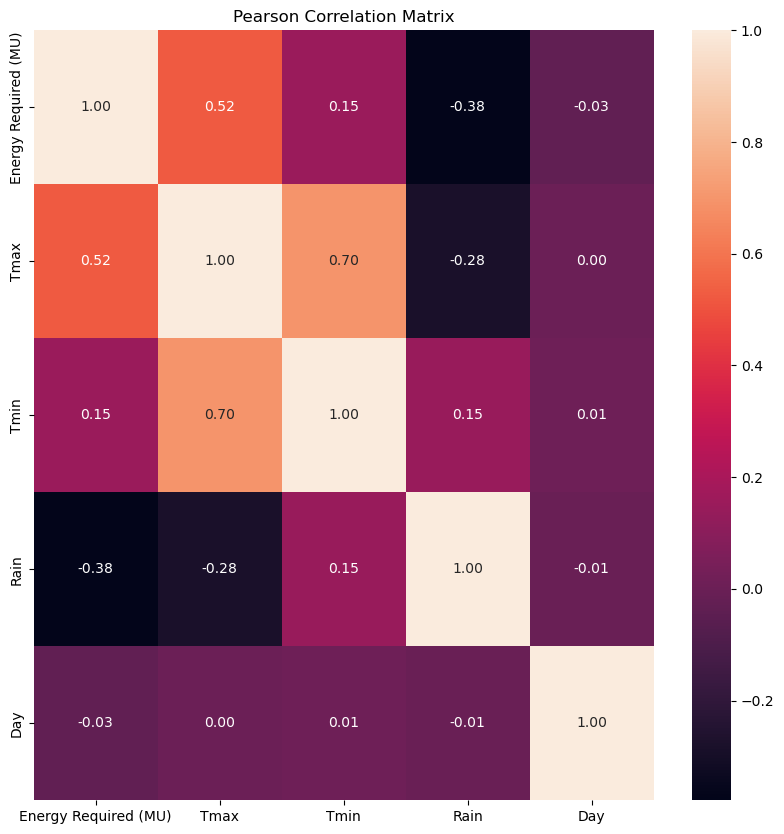

In [30]:
# plotting the correlation heatmap
correlations = merged_df.corr(method='pearson')
fig = plt.figure(figsize=(10, 10))
sns.heatmap(correlations, annot=True, fmt='.2f')
plt.title('Pearson Correlation Matrix')
plt.show()

In [31]:
#printing highly correlated features 
highly_correlated = abs(correlations[correlations > 0.75])
print(highly_correlated[highly_correlated < 1.0].stack().to_string())

Series([], )


In [289]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1595 entries, 2019-01-01 to 2023-05-14
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Energy Required (MU)  1595 non-null   float64
 1   inflation             1595 non-null   float64
 2   Holiday               1595 non-null   int64  
 3   Day                   1595 non-null   int64  
 4   Tmax                  1595 non-null   float64
 5   Tmin                  1595 non-null   float64
 6   Rain                  1595 non-null   float64
dtypes: float64(5), int64(2)
memory usage: 99.7 KB


In [290]:
merged_df.Holiday.unique()

array([0, 1])

In [291]:
merged_df[merged_df["Holiday"]=="Good Friday"]

Empty DataFrame
Columns: [Energy Required (MU), inflation, Holiday, Day, Tmax, Tmin, Rain]
Index: []

In [294]:
# Assuming you have a DataFrame named merged_df
merged_df = merged_df[columns].astype(float)


In [295]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1595 entries, 2019-01-01 to 2023-05-14
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Energy Required (MU)  1595 non-null   float64
 1   Rain                  1595 non-null   float64
 2   Tmax                  1595 non-null   float64
 3   Tmin                  1595 non-null   float64
 4   inflation             1595 non-null   float64
 5   Day                   1595 non-null   float64
 6   Holiday               1595 non-null   float64
dtypes: float64(7)
memory usage: 99.7 KB


In [293]:
columns=['Energy Required (MU)', 'Rain', 'Tmax','Tmin', 'inflation', 'Day','Holiday']

In [296]:
merged_df = merged_df.loc[:,columns]

In [297]:
merged_df

Energy Required (MU)      Rain       Tmax       Tmin  inflation  \
Date                                                                          
2019-01-01               152.233  0.000000  28.696802  14.070121      0.020   
2019-01-02               155.343  0.000000  29.149151  14.778795      0.020   
2019-01-03               157.659  0.000000  29.741541  15.863366      0.020   
2019-01-04               159.317  0.000000  29.451434  16.492335      0.020   
2019-01-05               159.691  0.000000  28.863384  16.951641      0.020   
...                          ...       ...        ...        ...        ...   
2023-05-10               218.349  0.293171  37.245505  26.819468      0.043   
2023-05-11               219.604  0.000000  37.272888  27.273576      0.043   
2023-05-12               224.523  0.814892  38.218507  26.842811      0.043   
2023-05-13               224.030  0.000000  38.145824  27.398606      0.043   
2023-05-14               226.349  0.000000  39.622750  27.568079      0.043   

            Day  Holiday  
Date                      
2019-01-01  1.0      0.0  
2019-01-02  2.0      0.0  
2019-01-03  3.0      0.0  
2019-01-04  4.0      0.0  
2019-01-05  5.0      0.0  
...         ...      ...  
2023-05-10  2.0      0.0  
2023-05-11  3.0      0.0  
2023-05-12  4.0      0.0  
2023-05-13  5.0      0.0  
2023-05-14  6.0      0.0  

[1595 rows x 7 columns]

In [298]:
#defining X and y for the model input
X = merged_df.values
y = merged_df['Energy Required (MU)'].values
y = y.reshape(-1, 1)


In [299]:
#shape of x
X.shape

(1595, 7)

In [300]:
#defining the end indices of train validation and test set
train_end_idx = 1202
cv_end_idx = 1412
test_end_idx = 1594

In [301]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

In [302]:
scaler_X.fit(X[:train_end_idx])
scaler_y.fit(y[:train_end_idx])

MinMaxScaler()

In [303]:
X_norm = scaler_X.transform(X)
y_norm = scaler_y.transform(y)

In [304]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []
    if start_index==0:
        start_index = start_index + history_size
    else:
        start_index=start_index
    if end_index is None:
        end_index = len(dataset) - target_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])
        
        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i : i + target_size])

    return np.array(data), np.array(labels)

In [305]:
dataset_norm = np.concatenate((X_norm, y_norm), axis=1)
n_features = 7
past_history = 15
future_target = 1

In [306]:
X_train, y_train = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, -1],
                                     0, train_end_idx, past_history, 
                                     future_target, step=1, single_step=True)

In [307]:
X_train.shape

(1187, 15, 7)

In [308]:
X_val, y_val = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                 train_end_idx, cv_end_idx, past_history, 
                                 future_target, step=1, single_step=True)

In [309]:
X_val.shape

(210, 15, 7)

In [310]:
X_test, y_test = multivariate_data(dataset_norm[:,0:-1], dataset_norm[:, 0],
                                   cv_end_idx, test_end_idx, past_history, 
                                   future_target, step=1, single_step=True)

In [311]:
X_test.shape

(182, 15, 7)

In [312]:
batch_size = 32
buffer_size = 1184

In [313]:
train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train = train.cache().shuffle(buffer_size).batch(batch_size).prefetch(1)

validation = tf.data.Dataset.from_tensor_slices((X_val, y_val))
validation = validation.batch(batch_size).prefetch(1)

In [314]:
# Define some common parameters

input_shape = X_train.shape[-2:]
loss = tf.keras.losses.MeanSquaredError()
metric = [tf.keras.metrics.RootMeanSquaredError()]
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
              lambda epoch: 1e-4 * 10**(epoch / 10))
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10)

In [166]:
def plot_model_rmse_and_loss(history):
    
    # Evaluate train and validation accuracies and losses
    train_rmse = history.history['root_mean_squared_error']
    val_rmse = history.history['val_root_mean_squared_error']
    
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    # Visualize epochs vs. train and validation accuracies and losses
    
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.plot(train_rmse, label='Training RMSE')
    plt.plot(val_rmse, label='Validation RMSE')
    plt.legend()
    plt.title('Epochs vs. Training and Validation RMSE')
    
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.legend()
    plt.title('Epochs vs. Training and Validation Loss')
    
    plt.show()

# **Vanila LSTM**

In [167]:
#Defining the model
tf.keras.backend.clear_session()

multivariate_lstm = tf.keras.models.Sequential([
    LSTM(100, input_shape=input_shape, 
         return_sequences=True),
    Flatten(),
    Dense(200, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

#defining the model checkpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_lstm.h5', monitor=('val_loss'), save_best_only=True)
#defining the optimizer
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [168]:
history = multivariate_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
38/38 [==============================] - 4s 35ms/step - loss: 0.0286 - root_mean_squared_error: 0.1691 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1274
Epoch 2/120
38/38 [==============================] - 1s 18ms/step - loss: 0.0106 - root_mean_squared_error: 0.1031 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1293
Epoch 3/120
38/38 [==============================] - 1s 21ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1180
Epoch 4/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0103 - root_mean_squared_error: 0.1015 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 5/120
38/38 [==============================] - 1s 20ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 6/120
38/38 [==============================] - 1s 19ms/step - loss: 0.0082 - root_mean_squared_error: 0.0907 - val_loss: 0.0124 - val_

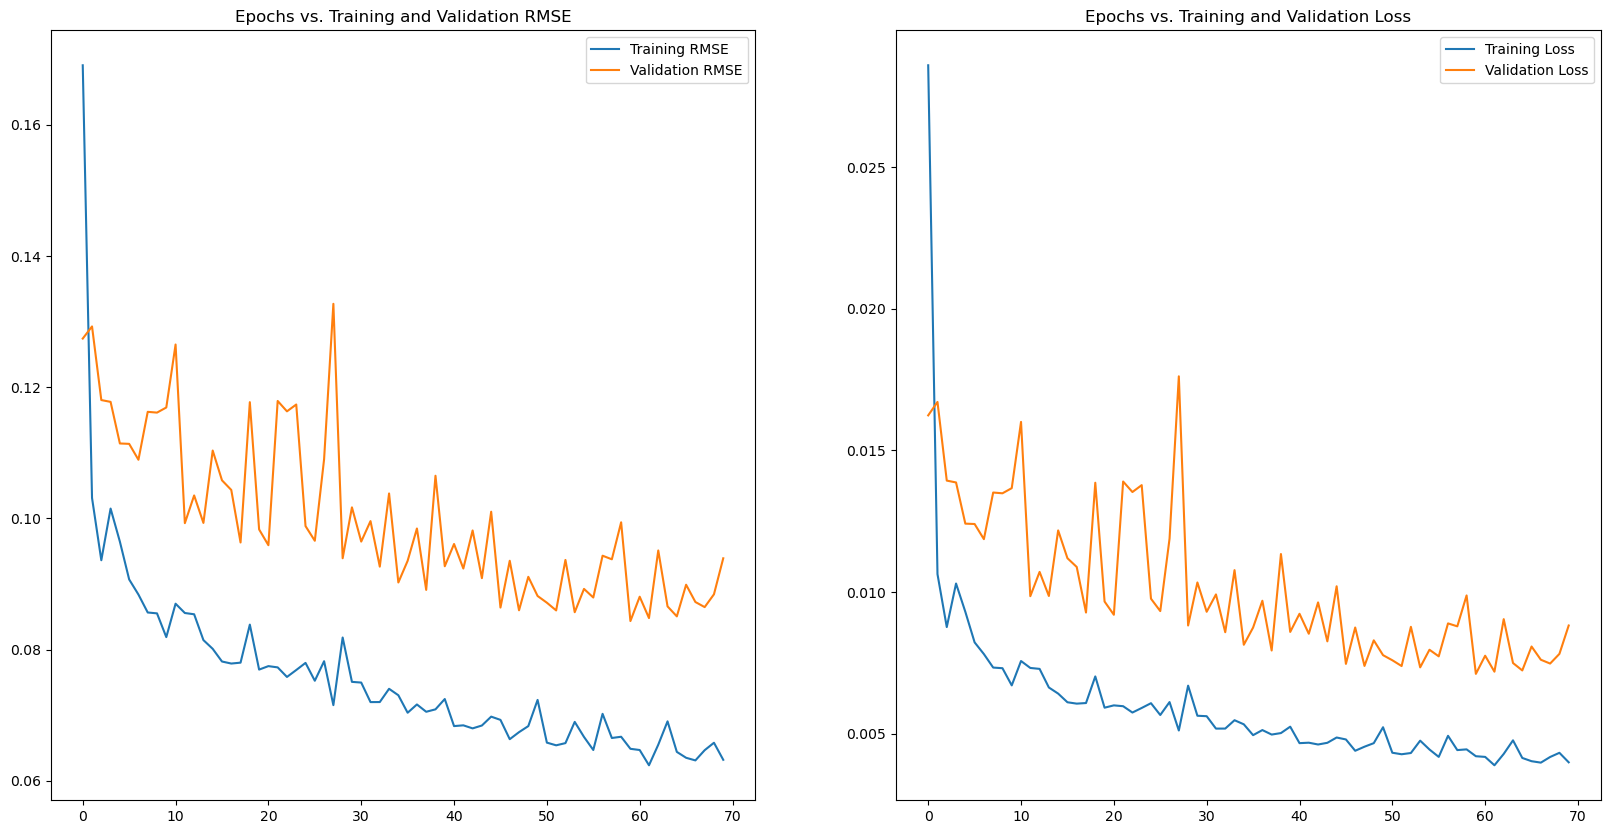

In [169]:
plot_model_rmse_and_loss(history)

In [170]:
y_test.shape

(182,)

In [171]:
# loading the best saved model
multivariate_lstm = tf.keras.models.load_model('multivariate_lstm.h5')

# preparing the y_test outputs
y_test = y_test.reshape(-1, 1)
#rescaling the y_test
y_test_inv = scaler_y.inverse_transform(y_test)
#predicting on the X_text
test_forecast = multivariate_lstm.predict(X_test)
lstm_forecast = scaler_y.inverse_transform(test_forecast)
print(y_test_inv.shape)
#rmse on test set
rmse_lstm = sqrt(mean_squared_error(y_test_inv,
                                    lstm_forecast))
print('RMSE of day ahead power demand LSTM forecast: {}'
      .format(round(rmse_lstm, 3)))

6/6 [==============================] - 1s 7ms/step
(182, 1)
RMSE of day ahead power demand LSTM forecast: 9.495


In [172]:
# predicting the training output and rescaling
train_forecast = multivariate_lstm.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)
start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_lstm.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)

1/1 [==============================] - 0s 25ms/step
Unseen data forecast : [[226.63974]]


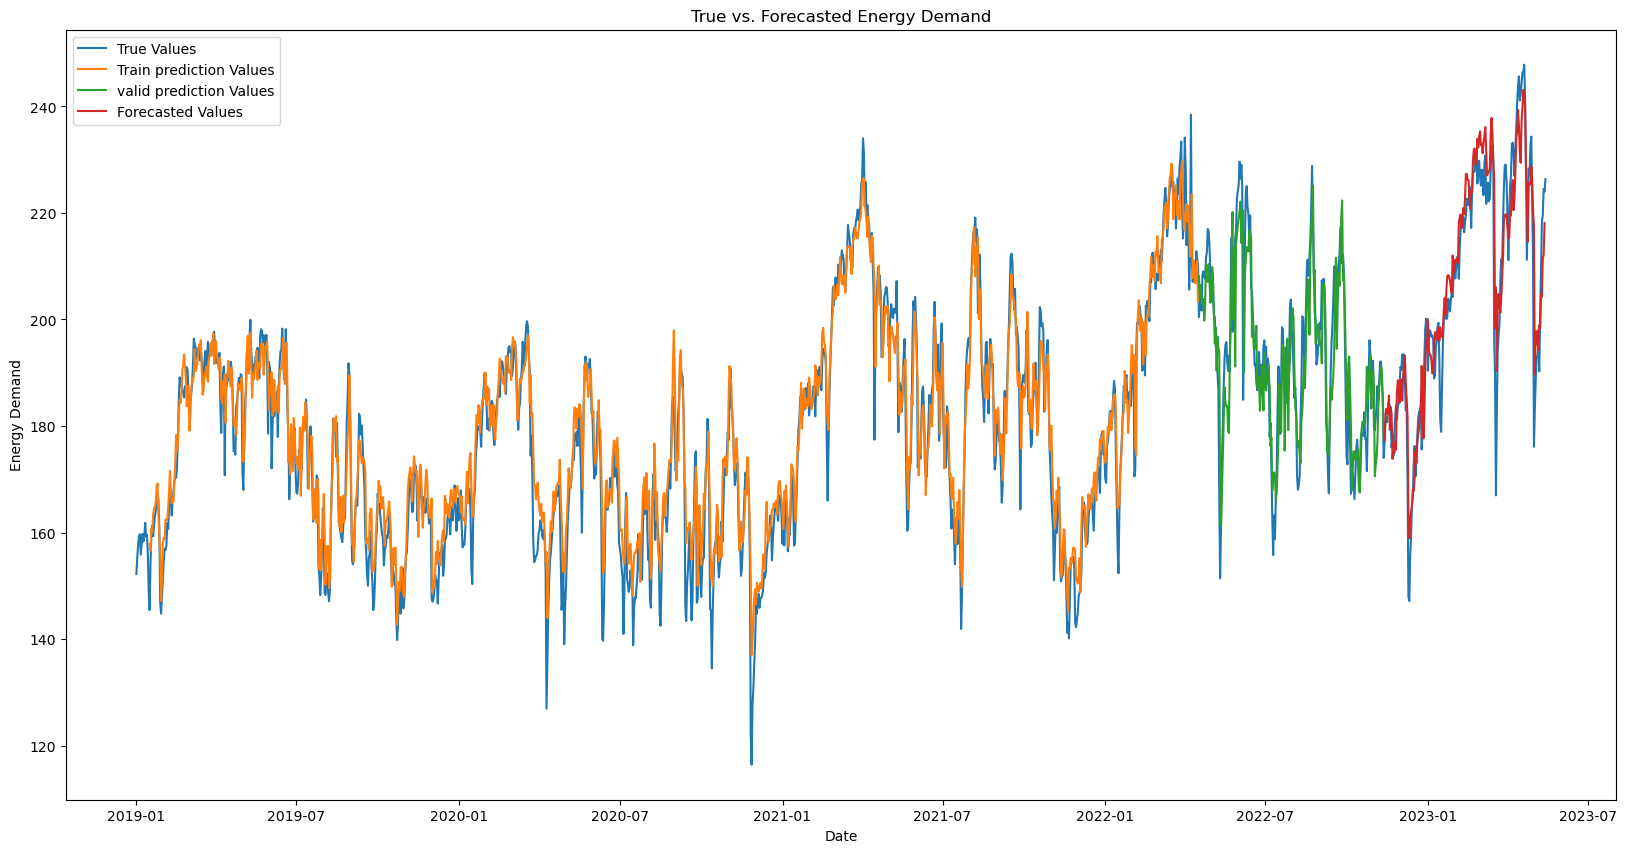

In [174]:
import matplotlib.pyplot as plt

# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Stacked LSTM**

In [175]:
tf.keras.backend.clear_session()

from tensorflow.keras.layers import LSTM, Dense, Dropout, Flatten, LeakyReLU

multivariate_stacked_lstm = tf.keras.models.Sequential([
    LSTM(250, input_shape=input_shape, return_sequences=True),
    LSTM(200, return_sequences=True),
    LSTM(150, return_sequences=True),
    Dropout(0.2),
    LSTM(100, return_sequences=True),
    LSTM(80,return_sequences = True),
     Dropout(0.1),
    LSTM(50, return_sequences = True),
    Flatten(),
    Dense(150),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])


model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_stacked_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=3e-3, amsgrad=True)

multivariate_stacked_lstm.compile(loss=loss,
                                  optimizer=optimizer,
                                  metrics=metric)

In [176]:
history = multivariate_stacked_lstm.fit(train, epochs=120,
                                validation_data=validation,
                                callbacks=[early_stopping, 
                                           model_checkpoint])

Epoch 1/120
38/38 [==============================] - 23s 218ms/step - loss: 0.0611 - root_mean_squared_error: 0.2307 - val_loss: 0.0404 - val_root_mean_squared_error: 0.2011
Epoch 2/120
38/38 [==============================] - 6s 145ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0323 - val_root_mean_squared_error: 0.1798
Epoch 3/120
38/38 [==============================] - 5s 144ms/step - loss: 0.0148 - root_mean_squared_error: 0.1216 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2169
Epoch 4/120
38/38 [==============================] - 6s 148ms/step - loss: 0.0154 - root_mean_squared_error: 0.1240 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1685
Epoch 5/120
38/38 [==============================] - 6s 146ms/step - loss: 0.0132 - root_mean_squared_error: 0.1148 - val_loss: 0.0284 - val_root_mean_squared_error: 0.1686
Epoch 6/120
38/38 [==============================] - 6s 148ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0307

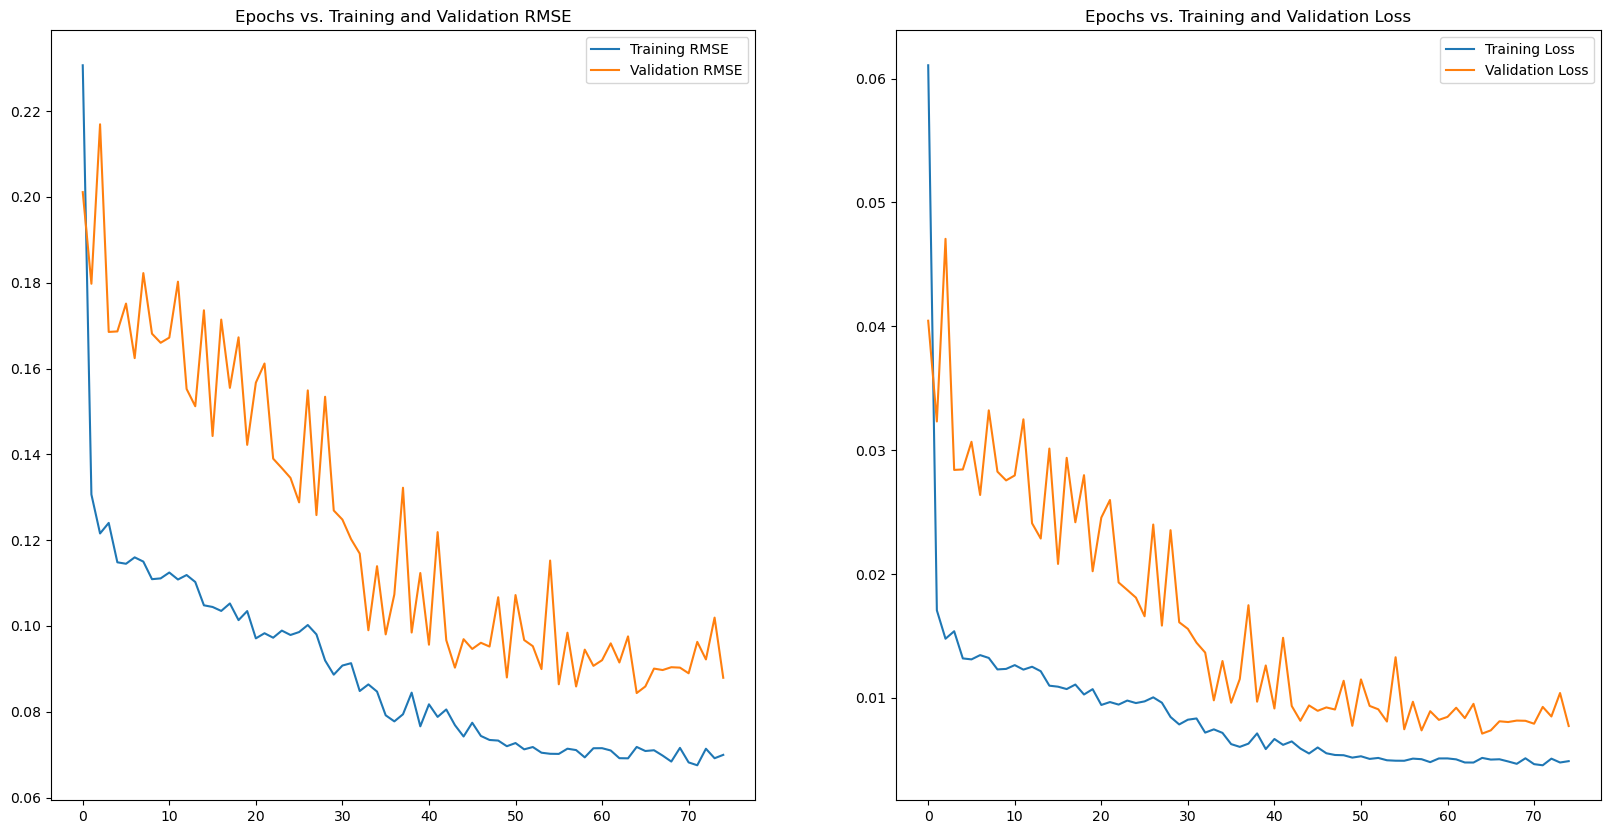

In [178]:
plot_model_rmse_and_loss(history)

In [179]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast = multivariate_stacked_lstm.predict(X_test)
multivariate_stacked_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_stacked_lstm = sqrt(mean_squared_error(y_test_inv, 
                                                 multivariate_stacked_lstm_forecast))
print('RMSE of day ahead power demand multivariate Stacked LSTM forecast: {}'
      .format(round(rmse_mult_stacked_lstm, 3)))


6/6 [==============================] - 3s 55ms/step
RMSE of day ahead power demand multivariate Stacked LSTM forecast: 11.203


In [180]:
multivariate_stacked_lstm = tf.keras.models.load_model('multivariate_stacked_lstm.h5')

forecast_unseen = multivariate_stacked_lstm.predict(X_test2)
lstm_forecast_unseen = scaler_y.inverse_transform(forecast_unseen)
print(lstm_forecast_unseen)

1/1 [==============================] - 3s 3s/step
[[219.28523]]


1/1 [==============================] - 0s 32ms/step
Unseen data forecast : [[219.28523]]


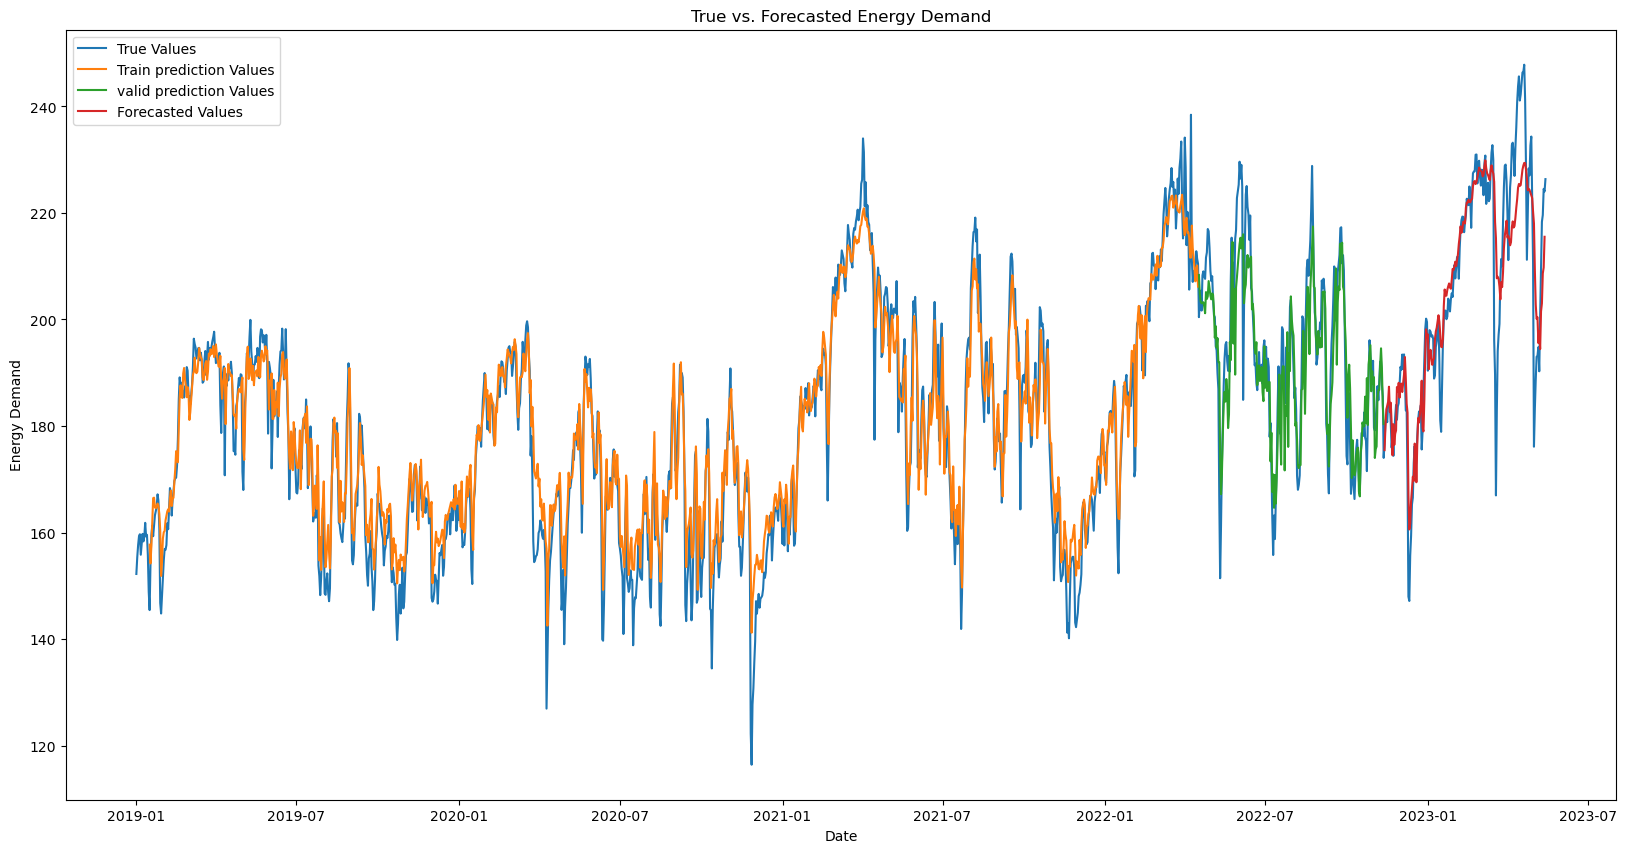

In [181]:
# predicting the training output and rescaling
train_forecast = multivariate_stacked_lstm.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_stacked_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_stacked_lstm.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_stacked_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN**

In [182]:
tf.keras.backend.clear_session()

multivariate_cnn = tf.keras.models.Sequential([
    Conv1D(filters=48, kernel_size=2,
           strides=1, padding='causal',
           activation='relu', 
           input_shape=input_shape),
    Flatten(),
    Dense(48, activation='relu'),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=6e-3, amsgrad=True)

multivariate_cnn.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [183]:
history = multivariate_cnn.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
38/38 [==============================] - 1s 8ms/step - loss: 0.0241 - root_mean_squared_error: 0.1471 - val_loss: 0.0162 - val_root_mean_squared_error: 0.1272
Epoch 2/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0083 - root_mean_squared_error: 0.0912 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1438
Epoch 3/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0076 - root_mean_squared_error: 0.0870 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1166
Epoch 4/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0073 - root_mean_squared_error: 0.0855 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 5/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0060 - root_mean_squared_error: 0.0776 - val_loss: 0.0116 - val_root_mean_squared_error: 0.1079
Epoch 6/120
38/38 [==============================] - 0s 4ms/step - loss: 0.0058 - root_mean_squared_error: 0.0764 - val_loss: 0.0108 - val_root_m

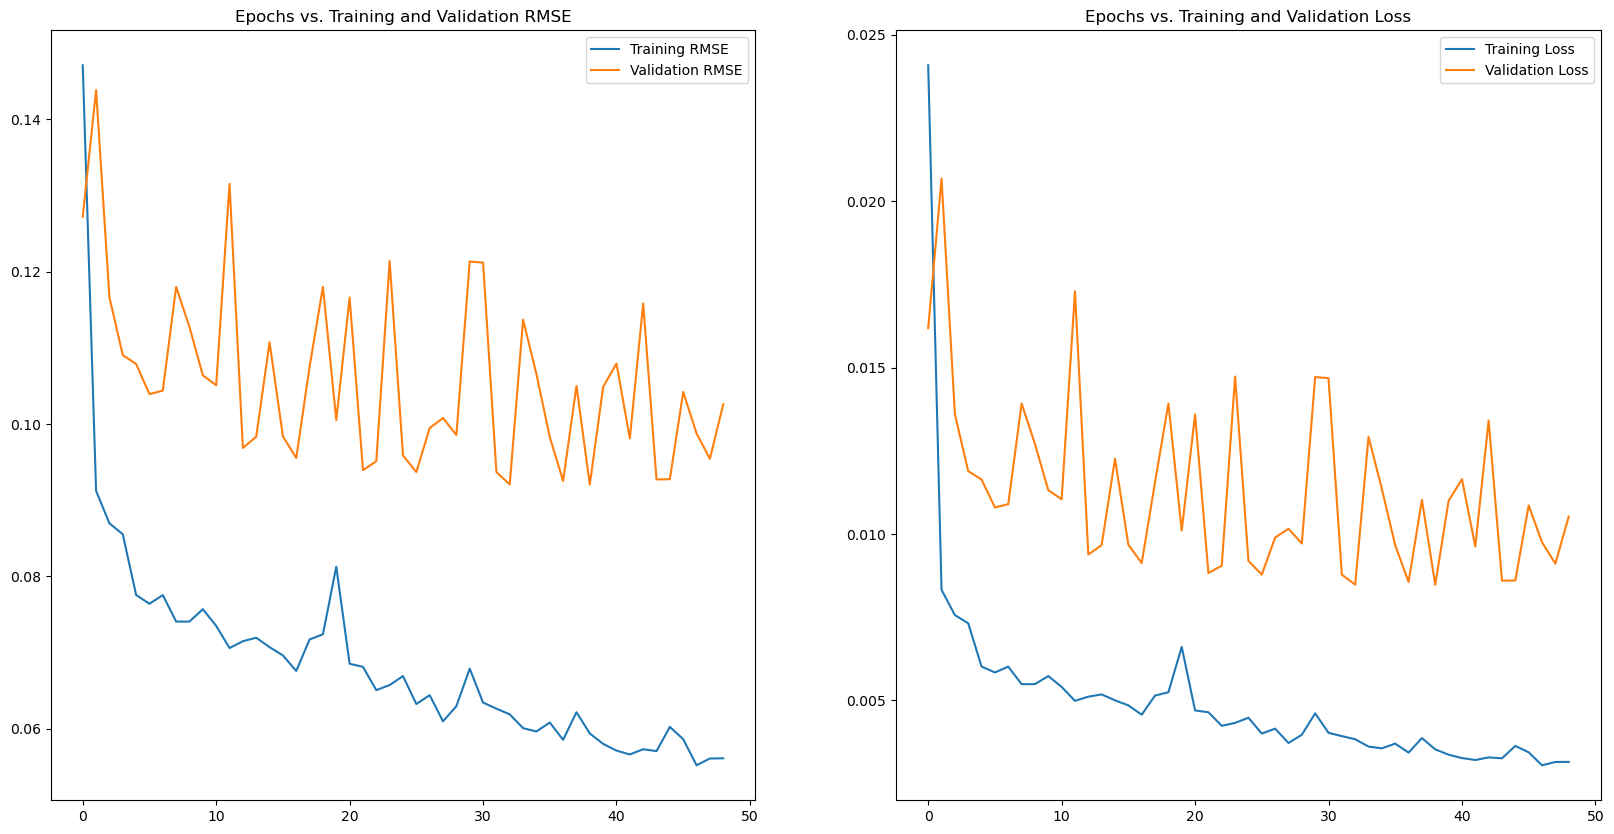

In [184]:
plot_model_rmse_and_loss(history)

In [185]:
multivariate_cnn = tf.keras.models.load_model('multivariate_cnn.h5')

forecast = multivariate_cnn.predict(X_test)
multivariate_cnn_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_cnn_forecast))
print('RMSE of day ahead electricity price multivariate CNN forecast: {}'
      .format(round(rmse_mult_cnn, 3)))

6/6 [==============================] - 0s 2ms/step
RMSE of day ahead electricity price multivariate CNN forecast: 10.833


1/1 [==============================] - 0s 23ms/step
Unseen data forecast : [[232.35333]]


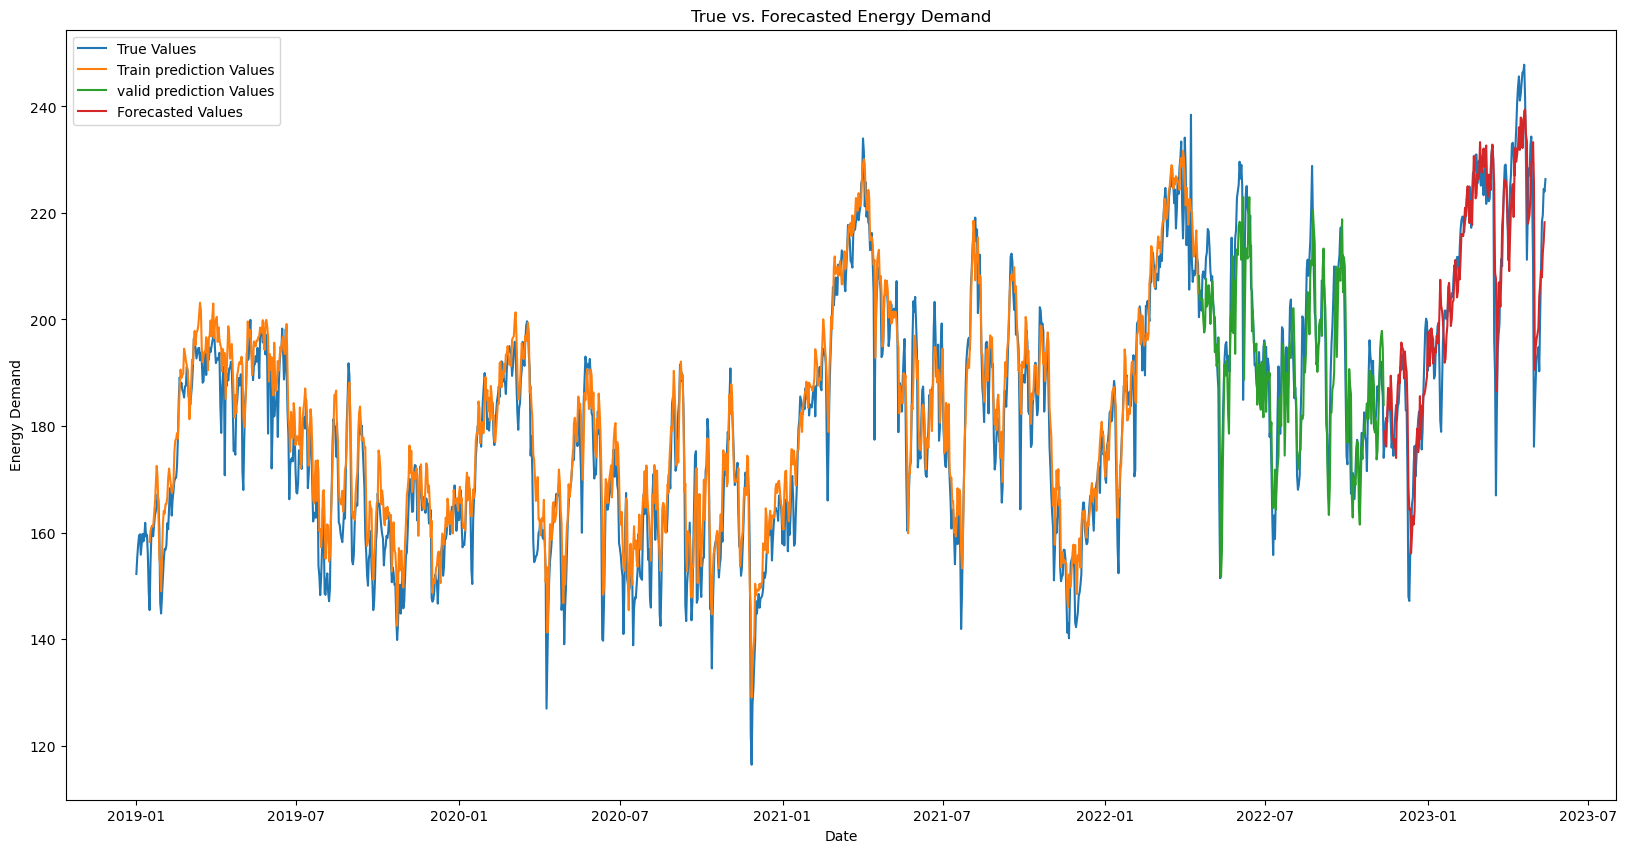

In [186]:
# predicting the training output and rescaling
train_forecast = multivariate_cnn.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_cnn.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_cnn.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_cnn_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **CNN- LSTM**

In [192]:
tf.keras.backend.clear_session()

multivariate_cnn_lstm = tf.keras.models.Sequential([
    Conv1D(filters=100, kernel_size=2,
           strides=1, padding='causal',
           activation='relu',
           input_shape=input_shape),

    LSTM(100),
    Flatten(),
    Dense(100),
    LeakyReLU(),
    Dropout(0.2),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_cnn_lstm.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=4e-3, amsgrad=True)

multivariate_cnn_lstm.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)


In [193]:
history = multivariate_cnn_lstm.fit(train, epochs=120,
                                    validation_data=validation,
                                    callbacks=[early_stopping, 
                                               model_checkpoint])

Epoch 1/120
38/38 [==============================] - 6s 39ms/step - loss: 0.0379 - root_mean_squared_error: 0.1826 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1239
Epoch 2/120
38/38 [==============================] - 1s 21ms/step - loss: 0.0090 - root_mean_squared_error: 0.0951 - val_loss: 0.0153 - val_root_mean_squared_error: 0.1236
Epoch 3/120
38/38 [==============================] - 1s 22ms/step - loss: 0.0081 - root_mean_squared_error: 0.0900 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 4/120
38/38 [==============================] - 1s 21ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893 - val_loss: 0.0117 - val_root_mean_squared_error: 0.1083
Epoch 5/120
38/38 [==============================] - 1s 20ms/step - loss: 0.0078 - root_mean_squared_error: 0.0883 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 6/120
38/38 [==============================] - 1s 21ms/step - loss: 0.0076 - root_mean_squared_error: 0.0872 - val_loss: 0.0123 - val_

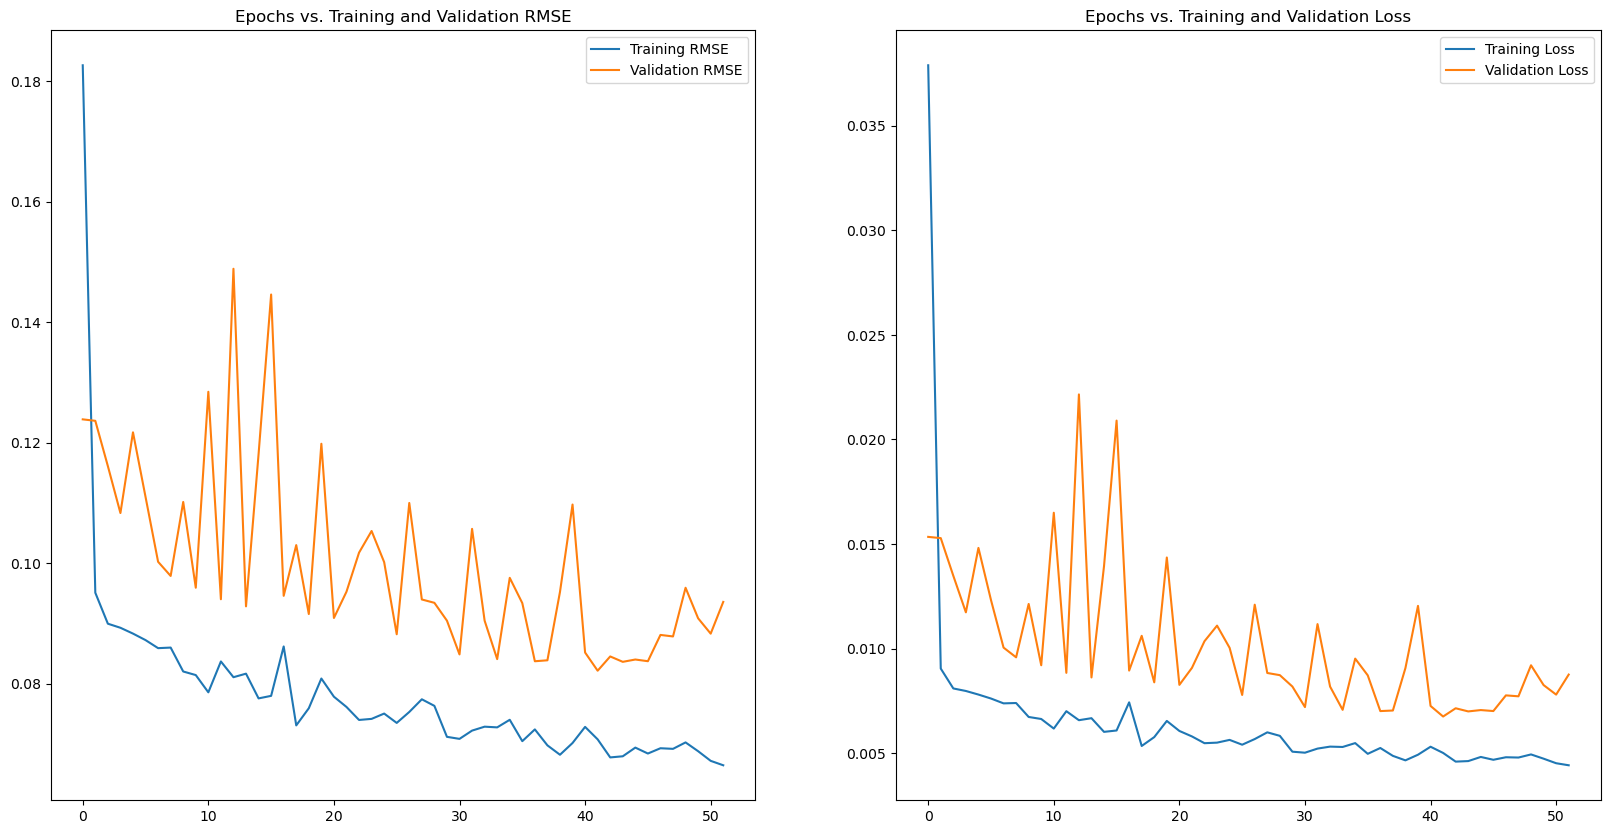

In [194]:
plot_model_rmse_and_loss(history)

In [195]:
multivariate_cnn_lstm = tf.keras.models.load_model('multivariate_cnn_lstm.h5')

forecast = multivariate_cnn_lstm.predict(X_test)
multivariate_cnn_lstm_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_cnn_lstm = sqrt(mean_squared_error(y_test_inv, 
                                             multivariate_cnn_lstm_forecast))
print('RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: {}'
      .format(round(rmse_mult_cnn_lstm, 3)))

6/6 [==============================] - 1s 6ms/step
RMSE of day-ahead power demand  multivariate CNN-`LSTM forecast: 9.523


1/1 [==============================] - 0s 26ms/step
Unseen data forecast : [[221.0258]]


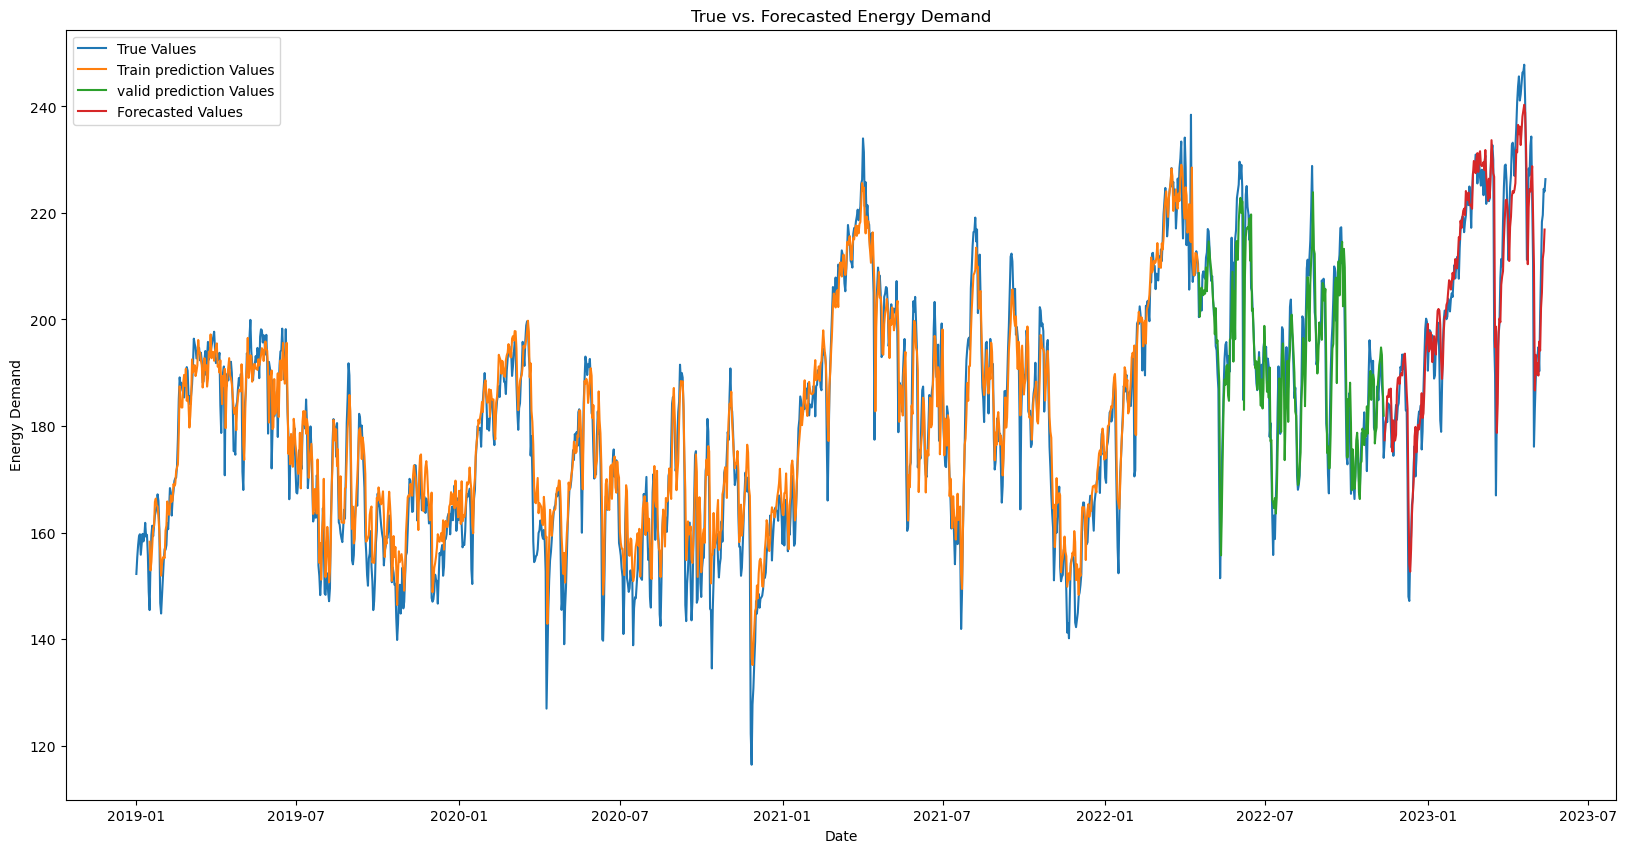

In [196]:
# predicting the training output and rescaling
train_forecast = multivariate_cnn_lstm.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_cnn_lstm.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_cnn_lstm.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_cnn_lstm_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Time Distributed MLP**

In [200]:
tf.keras.backend.clear_session()

multivariate_mlp = tf.keras.models.Sequential([
    TimeDistributed(Dense(100, activation='relu'),
                    input_shape=input_shape),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(150, activation='relu'),
    Dropout(0.1),
    Dense(1)
])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'multivariate_mlp.h5', save_best_only=True)
optimizer = tf.keras.optimizers.Adam(lr=2e-3, amsgrad=True)

multivariate_mlp.compile(loss=loss,
                          optimizer=optimizer,
                          metrics=metric)

In [201]:
history = multivariate_mlp.fit(train, epochs=120,
                               validation_data=validation,
                               callbacks=[early_stopping, 
                                          model_checkpoint])

Epoch 1/120
38/38 [==============================] - 2s 11ms/step - loss: 0.0441 - root_mean_squared_error: 0.1987 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1190
Epoch 2/120
38/38 [==============================] - 0s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0996 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 3/120
38/38 [==============================] - 0s 7ms/step - loss: 0.0080 - root_mean_squared_error: 0.0897 - val_loss: 0.0125 - val_root_mean_squared_error: 0.1117
Epoch 4/120
38/38 [==============================] - 0s 7ms/step - loss: 0.0074 - root_mean_squared_error: 0.0863 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 5/120
38/38 [==============================] - 0s 7ms/step - loss: 0.0072 - root_mean_squared_error: 0.0848 - val_loss: 0.0095 - val_root_mean_squared_error: 0.0973
Epoch 6/120
38/38 [==============================] - 0s 7ms/step - loss: 0.0065 - root_mean_squared_error: 0.0806 - val_loss: 0.0094 - val_root_

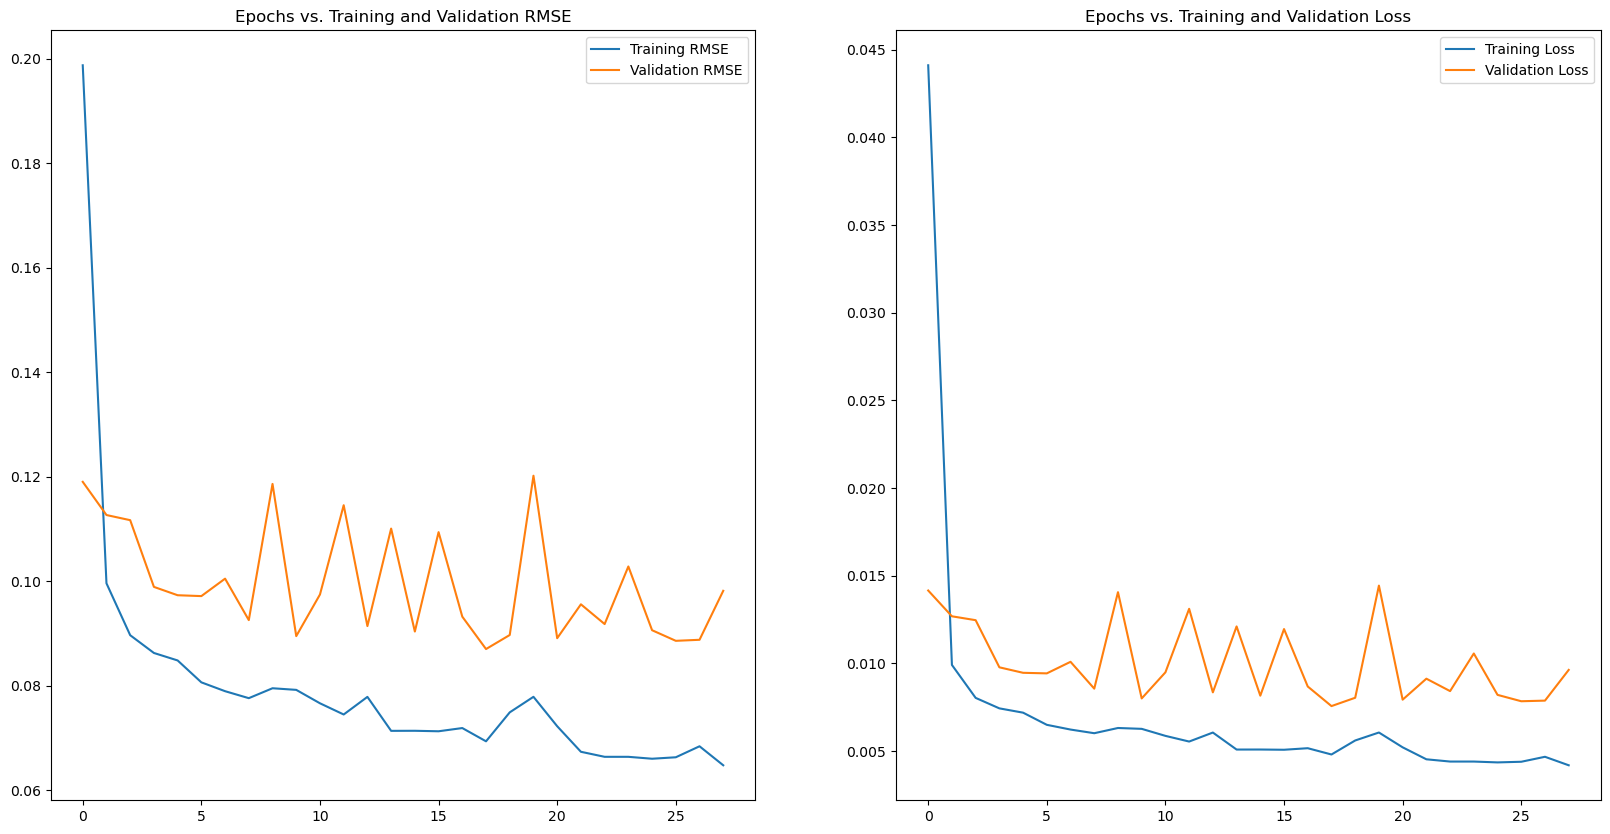

In [202]:
plot_model_rmse_and_loss(history)

In [203]:
multivariate_mlp = tf.keras.models.load_model('multivariate_mlp.h5')

forecast = multivariate_mlp.predict(X_test)
multivariate_mlp_forecast = scaler_y.inverse_transform(forecast)

rmse_mult_mlp = sqrt(mean_squared_error(y_test_inv,
                                        multivariate_mlp_forecast))
print('RMSE of day-ahead power demand multivariate MLP forecast: {}'
      .format(round(rmse_mult_mlp, 3)))

6/6 [==============================] - 0s 3ms/step
RMSE of day-ahead power demand multivariate MLP forecast: 11.09


1/1 [==============================] - 0s 24ms/step
Unseen data forecast : [[222.5471]]


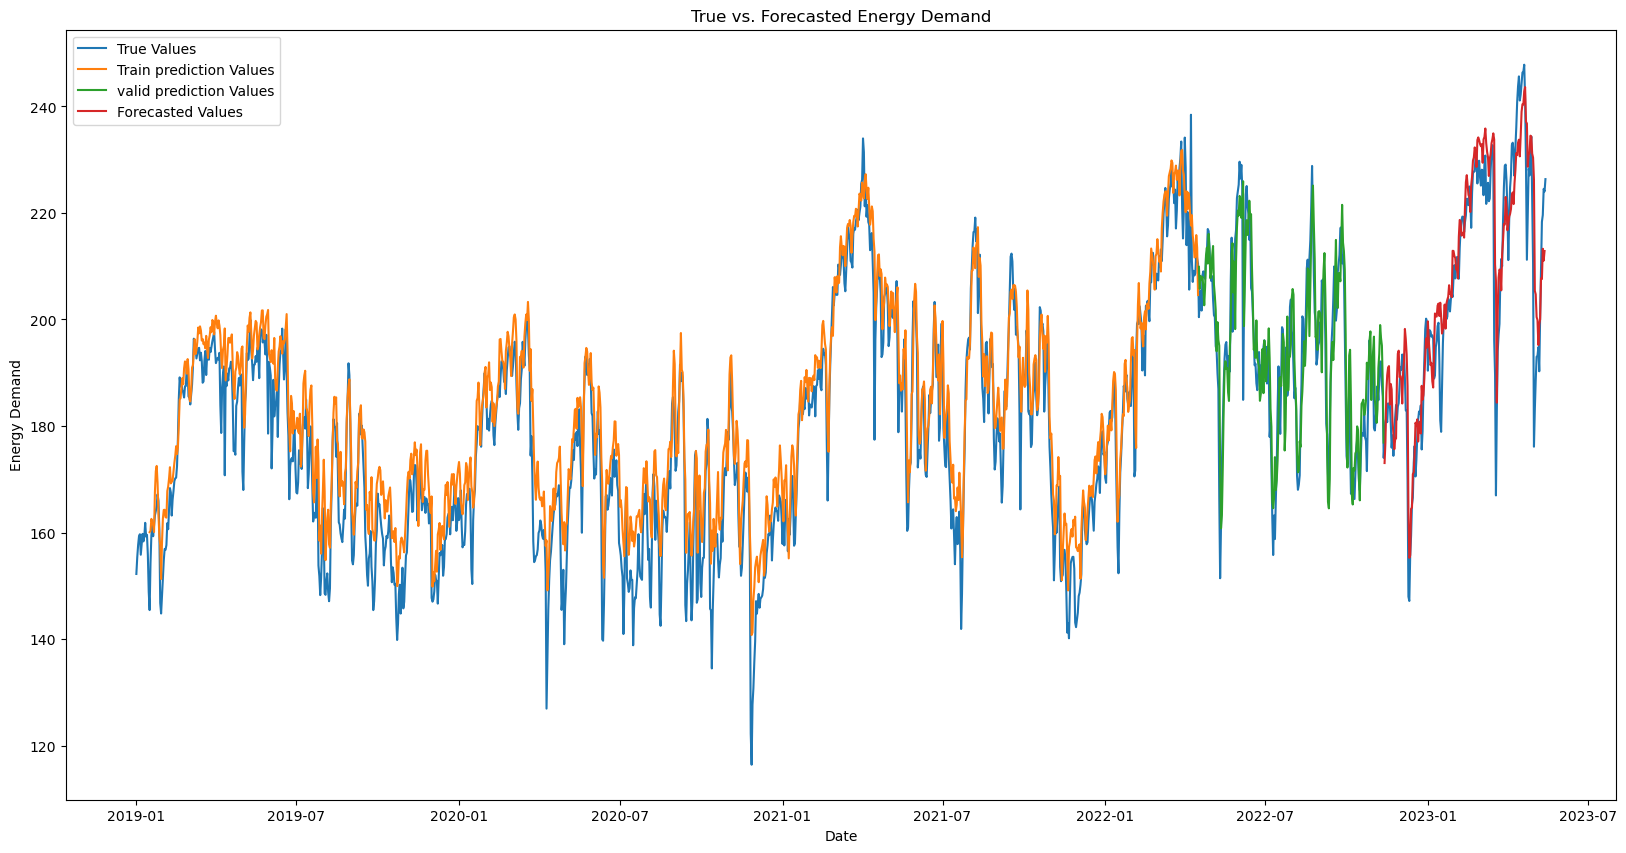

In [204]:
# predicting the training output and rescaling
train_forecast = multivariate_mlp.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_mlp.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history
#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)
#prediction using the trained model
forecast_unseen = multivariate_mlp.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# Assuming merged_df is your DataFrame with the date column set as the index
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, multivariate_mlp_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


# **Encoder Decoder**

In [206]:
tf.keras.backend.clear_session()

encoder_decoder = tf.keras.models.Sequential([
    LSTM(100, activation='relu', input_shape=input_shape),
    RepeatVector(past_history),
    LSTM(50, activation='relu', return_sequences=True),
    TimeDistributed(Dense(50, activation='relu')),
    Flatten(),
    Dense(25, activation='relu'),
    Dense(1)
])



model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
                   'encoder_decoder.h5', save_best_only=True)

optimizer = tf.keras.optimizers.Adam(lr=1e-3, amsgrad=True)

encoder_decoder.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=metric)

In [207]:
history = encoder_decoder.fit(train, epochs=120,
                              validation_data=validation,
                              callbacks=[early_stopping, 
                                         model_checkpoint])

Epoch 1/120
38/38 [==============================] - 5s 38ms/step - loss: 0.0331 - root_mean_squared_error: 0.1719 - val_loss: 0.0302 - val_root_mean_squared_error: 0.1738
Epoch 2/120
38/38 [==============================] - 1s 27ms/step - loss: 0.0079 - root_mean_squared_error: 0.0888 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1138
Epoch 3/120
38/38 [==============================] - 1s 26ms/step - loss: 0.0065 - root_mean_squared_error: 0.0804 - val_loss: 0.0169 - val_root_mean_squared_error: 0.1300
Epoch 4/120
38/38 [==============================] - 1s 27ms/step - loss: 0.0068 - root_mean_squared_error: 0.0822 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1064
Epoch 5/120
38/38 [==============================] - 1s 25ms/step - loss: 0.0059 - root_mean_squared_error: 0.0771 - val_loss: 0.0152 - val_root_mean_squared_error: 0.1234
Epoch 6/120
38/38 [==============================] - 1s 25ms/step - loss: 0.0059 - root_mean_squared_error: 0.0766 - val_loss: 0.0128 - val_

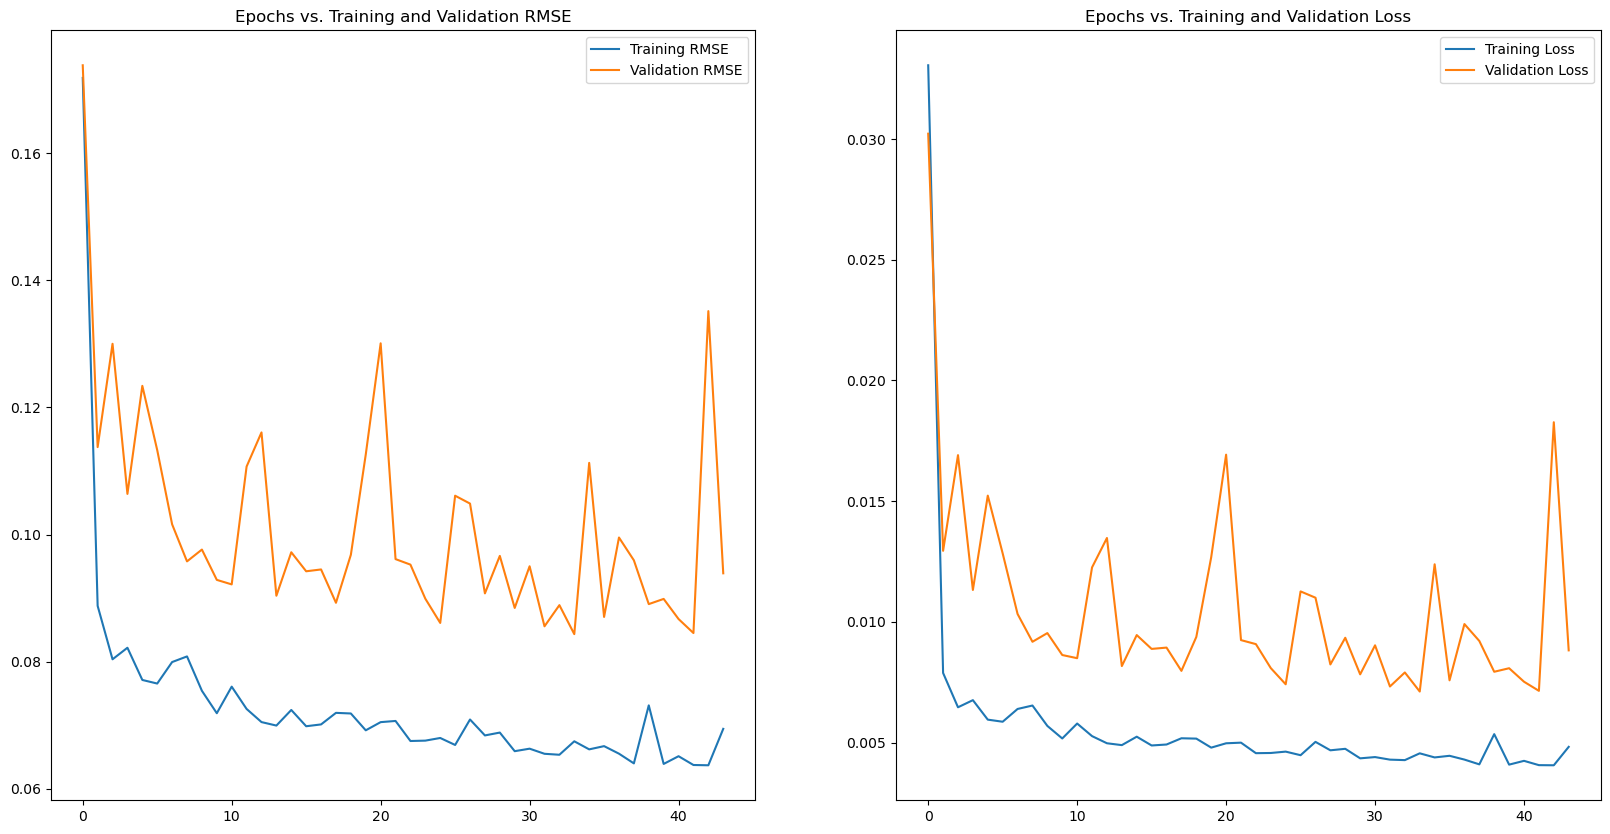

In [208]:
plot_model_rmse_and_loss(history)

In [209]:
encoder_decoder = tf.keras.models.load_model('encoder_decoder.h5')

forecast = encoder_decoder.predict(X_test)
encoder_decoder_forecast = scaler_y.inverse_transform(forecast)
rmse_encoder_decoder = sqrt(mean_squared_error(y_test_inv, 
                                               encoder_decoder_forecast))
print('RMSE of day ahead power demand Encoder-Decoder forecast: {}'
      .format(round(rmse_encoder_decoder, 3)))

6/6 [==============================] - 0s 10ms/step
RMSE of day ahead power demand Encoder-Decoder forecast: 9.724


1/1 [==============================] - 0s 23ms/step
Unseen data forecast : [[222.5471]]


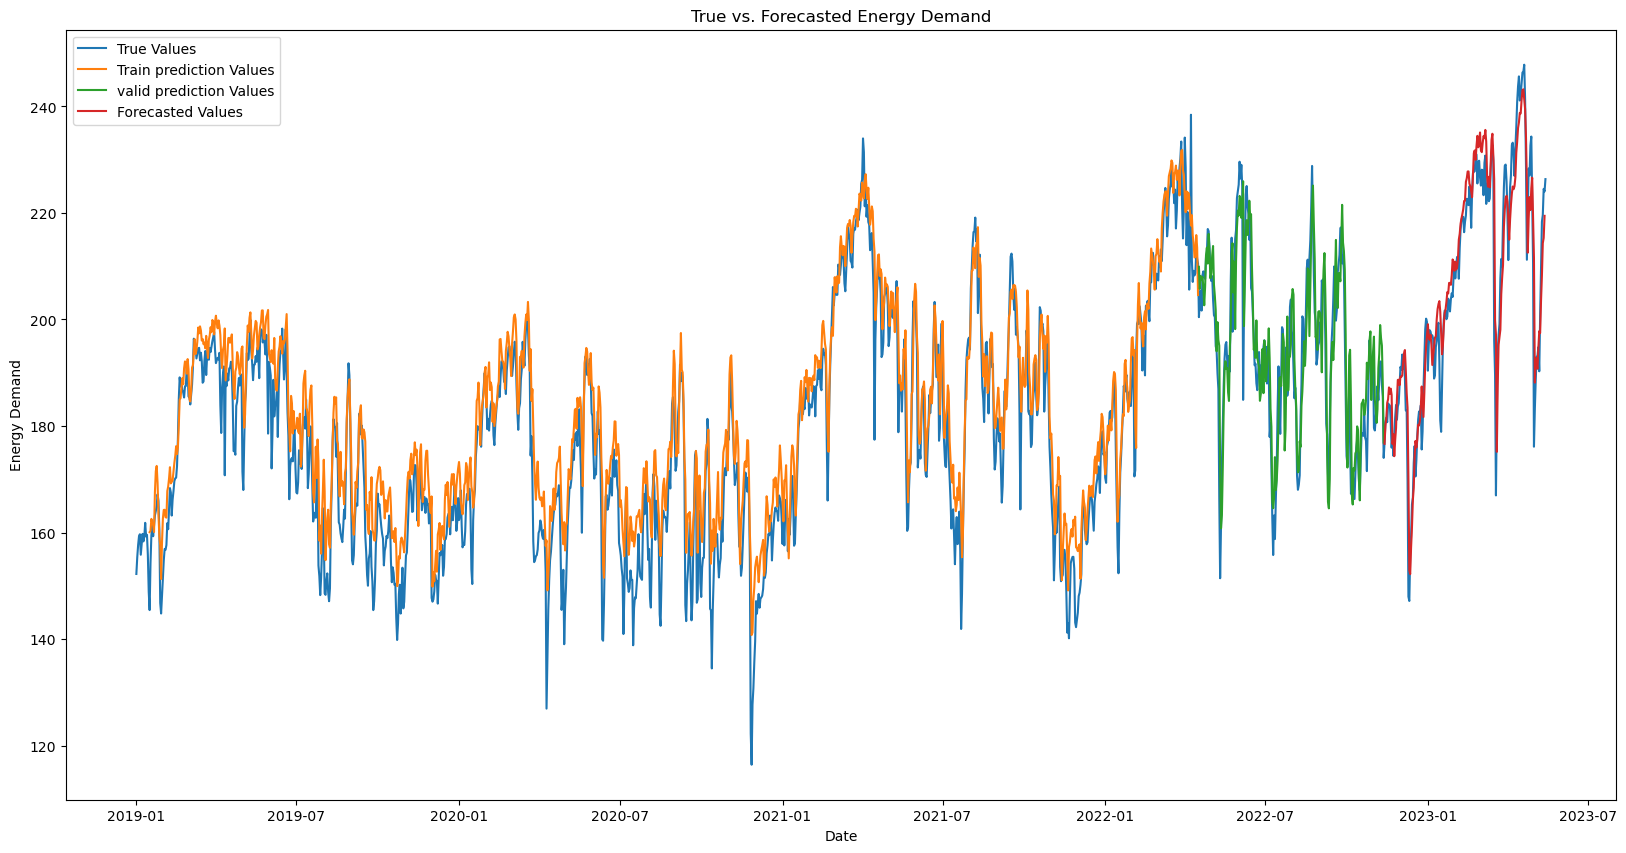

In [210]:
# predicting the training output and rescaling
train_forecast = multivariate_mlp.predict(X_train)
train_forecast_inverse = scaler_y.inverse_transform(train_forecast)

#predicting the validation output and rescaling
valid_forecast = multivariate_mlp.predict(X_val)
valid_forecast_inverse = scaler_y.inverse_transform(valid_forecast)

#start and end indices for the X_test2 
start_idx = X_train.shape[0]+X_val.shape[0]+X_test.shape[0]+1
end_idx = start_idx+ past_history

#preparing the test set for future day ahead forecast
X_test2 = scaler_X.transform(X[start_idx:end_idx,:])
X_test2 = X_test2.reshape(1,past_history,n_features)

#prediction using the trained model
forecast_unseen = multivariate_mlp.predict(X_test2)
forecast_unseen_inverse = scaler_y.inverse_transform(forecast_unseen)
print("Unseen data forecast :",forecast_unseen_inverse)


# true energy demand values
true_values = merged_df['Energy Required (MU)'].values

# Create arrays for the x-axis (dates)
dates_true = merged_df.index[:len(merged_df)]
dates_train_pred = merged_df.index[past_history:train_end_idx]
dates_valid_pred = merged_df.index[train_end_idx:cv_end_idx]
dates_forecasted = merged_df.index[cv_end_idx:test_end_idx]
dates_unseen = merged_df.index[start_idx:end_idx]


# Plotting the true values and forecasted values
plt.figure(figsize=(20, 10))
plt.plot(dates_true, true_values[:len(merged_df)], label='True Values')
plt.plot(dates_train_pred, train_forecast_inverse, label='Train prediction Values')
plt.plot(dates_valid_pred, valid_forecast_inverse, label='valid prediction Values')
plt.plot(dates_forecasted, encoder_decoder_forecast, label='Forecasted Values')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('True vs. Forecasted Energy Demand')
plt.legend()

'''# Adding another plot for unseen predictions
plt.figure(figsize=(12, 6))
plt.plot(dates_unseen, forecasted_values[161:], label='Unseen Predictions')  # Adjust the number of forecasted values
plt.xlabel('Date')
plt.ylabel('Energy Demand')
plt.title('Unseen Predictions')
plt.legend()'''

plt.show()


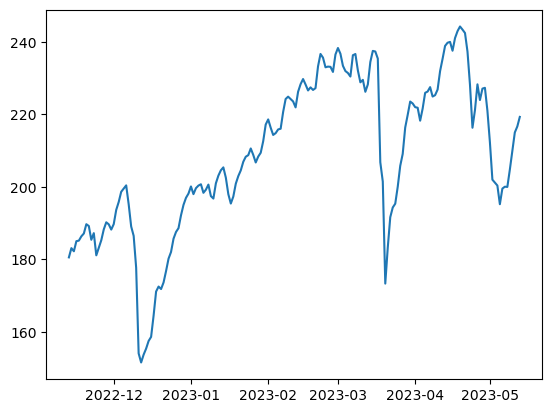

In [91]:
plt.plot(dates_forecasted,encoder_decoder_forecast, label='Forecasted Values') 

In [507]:
merged_df[:-1]

Energy Required (MU)       Tmax       Tmin      Rain  Day
2019-01-01               152.233  28.696802  14.070121  0.000000    1
2019-01-02               155.343  29.149151  14.778795  0.000000    2
2019-01-03               157.659  29.741541  15.863366  0.000000    3
2019-01-04               159.317  29.451434  16.492335  0.000000    4
2019-01-05               159.691  28.863384  16.951641  0.000000    5
...                          ...        ...        ...       ...  ...
2023-05-07               209.127  36.793343  26.633903  1.808096    1
2023-05-08               218.349  37.245505  26.819468  0.293171    2
2023-05-09               219.604  37.272888  27.273576  0.000000    3
2023-05-10               224.523  38.218507  26.842811  0.814892    4
2023-05-11               224.030  38.145824  27.398606  0.000000    5

[1592 rows x 5 columns]